# Online Retail II - Assignment 01 - Machine Learning Analysis

**Student:** Rellika Kisyula  
**Date:** November 6, 2025  

---

## 1. Data Overview

**Dataset Source:** [UCI Online Retail II](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II)

### 1.1 Dataset Overview

The **Online Retail II** dataset contains transactional data from a UK-based online retailer specializing in gift and home products. The data covers transactions from **December 2009 to December 2011**.

### 1.2 Data Dictionary

| Variable      | Type        | Description                  | Business Meaning                           |
|---------------|-------------|------------------------------|--------------------------------------------|
| `InvoiceNo`   | Categorical | Transaction number           | Unique sale transaction ID                 |
| `StockCode`   | Categorical | Product code                 | Unique identifier for each product         |
| `Description` | Text        | Product name                 | Product details for analysis               |
| `Quantity`    | Numeric     | Units purchased              | Measures demand volume                     |
| `InvoiceDate` | Datetime    | Date and time of transaction | Used for trend, seasonality, and recency   |
| `Price`       | Numeric     | Price per unit (in GBP)      | Indicates pricing strategy                 |
| `Customer ID` | Categorical | Unique customer identifier   | Enables customer segmentation & prediction |
| `Country`     | Categorical | Country of customer          | Geographic market analysis                 |

---
## 2.THE BUSINESS CHALLENGE
### 2.1 Business Problem 1: Customer Churn Prediction (Classification)
- PROBLEM: Predict which customers will NOT return within 90 days - **Based on a customer’s past behavior, can we predict if they will return in the next 90 days?**

- APPROACH: Binary classification using temporal split
- TARGET: will_return_90days (0 = Churned, 1 = Returned)

#### Variables
1. **Dependent Variable (DV):** `will_return_90days` (0 = Churned, 1 = Returned)
2. **Independent Variables (IVs):**
    - `recency_days`: Days since last purchase
    - `frequency`: Number of transactions
    - `avg_order_value`: Average spending per transaction
    - `purchase_consistency`: Std of days between purchases
    - `total_unique_products`: Product variety
    - `country`: Geographic location
    - `tenure_days`: Customer lifetime
3. **Model Type:**
    1. Logistic Regression (baseline, interpretable)
    2. Random Forest Classifier (non-linear patterns)


###  2.2 Business Problem 3: Product Recommendation System (Association Rules Mining)
PROBLEM: Find products frequently bought together to improve cross-selling
APPROACH: Market Basket Analysis using Apriori algorithm
OUTPUT: Association rules (if X purchased, then Y likely purchased)

TECHNIQUES:
- Apriori Algorithm: Find frequent itemsets
- Association Rules: Generate if-then relationships
- Metrics: Support, Confidence, Lift

BUSINESS VALUE:
- Product bundling strategies
- Store layout optimization
- Personalized recommendations
- Cross-selling opportunities


---

## 3. Data Acquisition and Loading

In [2]:
# important libraries to install
# !pip install pyjanitor plotnine pandas matplotlib numpy openpyxl pyarrow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
# !pip install pyjanitor
import janitor
import shap


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# If not installed, run these once in a cell:
# !pip install imbalanced-learn xgboost shap lifelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Note: mlxtend is required for Apriori
# Install:
# !pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


### 3.1 Loading the Data

In [4]:
def read_retail_data():
    # Load the dataset from both sheets
    file_path = "data/online_retail_II.xlsx"

    print("Loading data from both sheets...")
    print("=" * 60)

    # Read Year 2009-2010 sheet
    df_2009_2010 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
    print(f"Year 2009-2010 Sheet: {df_2009_2010.shape[0]:,} rows")

    # Read Year 2010-2011 sheet
    df_2010_2011 = pd.read_excel(file_path, sheet_name='Year 2010-2011')
    print(f"Year 2010-2011 Sheet: {df_2010_2011.shape[0]:,} rows")

    # Combine both sheets
    df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)

    print("=" * 60)
    print(f"\nCombined Dataset Shape: {df.shape}")
    print(f"Total Transactions: {df.shape[0]:,}")
    print(f"Total Features: {df.shape[1]}")
    print(f"\nDate Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
    return df.to_csv("data/online_retail_II_combined.csv", index=False)

# Load the data
# df = read_retail_data()

In [ ]:
# Load from CSV for faster access in future
original_df = pd.read_csv("data/online_retail_II_combined.csv", parse_dates=['InvoiceDate'])

In [6]:
df = original_df.copy()

### 3.2 Data Quality Assessment

In [7]:
# Display first few rows
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [8]:
# Summary statistics for numeric columns
df[['Quantity', 'Price']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0


In [9]:
# Check missing values
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})

print("\nMissing Values Summary:")
missing_summary[missing_summary['Missing Count'] > 0]


Missing Values Summary:


,Missing Count,Percentage
Customer ID,243007,22.766873
Description,4382,0.410541


In [10]:
# Check for negative values in Quantity and Price
negative_quantity = (df['Quantity'] < 0).sum()
negative_price = (df['Price'] < 0).sum()

print(f"\nNegative Quantity Records: {negative_quantity}")
print(f"Negative Price Records: {negative_price}")


Negative Quantity Records: 22950
Negative Price Records: 5


In [11]:
# check for duplicate rows
duplicate_rows = df.duplicated().sum()

print(f"\nDuplicate Rows: {duplicate_rows}")



Duplicate Rows: 34335


**Data Quality Issues:**
- ~22% of records are missing CustomerID (likely guest purchases)
- Small percentage missing Description
- Negative values in Quantity and UnitPrice indicate returns/cancellations
- Some duplicate records present around 34335 records

In [12]:
# Check for unique values in categorical columns
print(f"  Unique Invoices: {df['Invoice'].nunique():,}")

  Unique Invoices: 53,628


In [13]:
print(f"  Unique Products: {df['StockCode'].nunique():,}")

  Unique Products: 5,305


In [14]:
print(f"  Unique Customers: {df['Customer ID'].nunique():,}")

  Unique Customers: 5,942


In [15]:
print(f"  Countries: {df['Country'].nunique()}")

  Countries: 43


In [16]:
print(f"\nDate Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")


Date Range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00


In [17]:
# Top 10 countries by transaction count
print("Top 10 Countries by Transaction Count:")
df['Country'].value_counts().head(10)

Top 10 Countries by Transaction Count:


Country
United Kingdom    981330
EIRE               17866
Germany            17624
France             14330
Netherlands         5140
Spain               3811
Switzerland         3189
Belgium             3123
Portugal            2620
Australia           1913
Name: count, dtype: int64

### 3.3 Data Cleaning Strategy

1. Remove cancellations (Invoice starts with 'C')
2. Remove negative quantities (returns)
3. Remove zero/negative prices (errors)
4. Remove missing CustomerIDs (can't track behavior)
5. Remove missing descriptions

In [ ]:
## use janitor to clean column names
df = df.clean_names()

# rename invoicedaate to invoice_date
df = df.rename(columns={'invoicedate': 'invoice_date'})

# customer_id is category column
df['customer_id'] = df['customer_id'].astype('category')
# trim whitespace from description
df['description'] = df['description'].str.strip()

df.head()

,invoice,stockcode,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [19]:
# Remove duplicates
df = df.drop_duplicates()

# see if there are any duplicates left
df.duplicated().sum()

np.int64(0)

In [20]:
# Remove missing values from customer_id and description
df = df.dropna(subset=['customer_id', 'description'])

# Check missing values again
df.isnull().sum()

invoice         0
stockcode       0
description     0
quantity        0
invoice_date    0
price           0
customer_id     0
country         0
dtype: int64

In [21]:
# Remove cancellations and invalid values
# Remove cancellations first
df = df[~df['invoice'].astype(str).str.startswith('C')]

# Remove invalid numeric rows
df = df[(df['quantity'] > 0) & (df['price'] > 0)]


# check if any negative or zero values remain
print(f"Negative or Zero Quantity Records: {(df['quantity'] <= 0).sum()}")
print(f"Negative or Zero Price Records: {(df['price'] <= 0).sum()}")

Negative or Zero Quantity Records: 0
Negative or Zero Price Records: 0


In [22]:
# Convert data types
df['customer_id'] = df['customer_id'].astype(str)
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')

In [23]:
# see final shape after cleaning
print(f"Final Dataset Shape after Cleaning: {df.shape}")

Final Dataset Shape after Cleaning: (779425, 8)


---
### 4. Feature Engineering
1. Create Revenue = Quantity × UnitPrice
2. Extract temporal features (Year, Month, Day, Hour, DayOfWeek)

In [24]:
# Create Revenue column
df['revenue'] = df['quantity'] * df['price']
# Extract month day_of_week and hour from InvoiceDate
df['month'] = df['invoice_date'].dt.month_name()
df['day_of_week'] = df['invoice_date'].dt.day_name()
df['hour'] = df['invoice_date'].dt.hour
# Create CustomerType column
df['customer_type'] = np.where(df.duplicated(subset=['customer_id'], keep=False), 'Returning', 'New')
df.head()

,invoice,stockcode,description,quantity,invoice_date,price,customer_id,country,revenue,month,day_of_week,hour,customer_type
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,December,Tuesday,7,Returning
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,December,Tuesday,7,Returning
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,December,Tuesday,7,Returning
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,December,Tuesday,7,Returning
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,December,Tuesday,7,Returning


---
## 5. Exploratory Data Analysis: Understanding Customer Behavior

### 5.1 Revenue Distribution

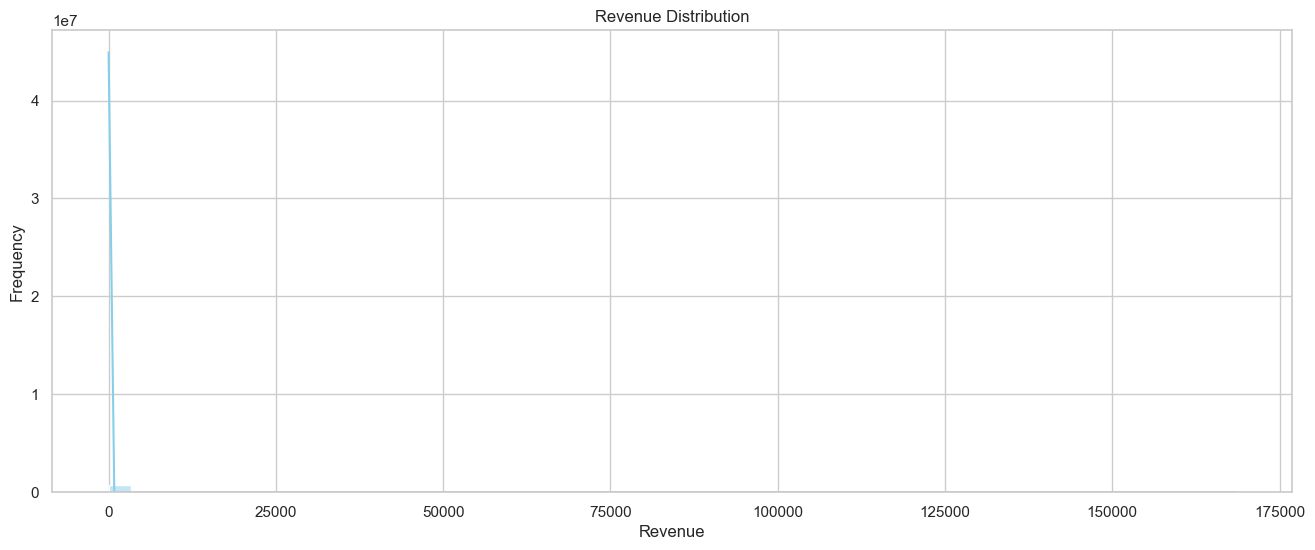

In [25]:
plt.figure(figsize=(16, 6))
sns.histplot(df['revenue'], bins=50, kde=True, color='skyblue')
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

The raw revenue distribution is extremely skewed, with a long right tail caused by very large transactions. Most orders generate only a few pounds of revenue, while a small number of transactions reach tens of thousands of pounds. This skew makes the histogram hard to interpret because the extreme values dominate the scale.

In [26]:
df[['revenue', 'quantity', 'price']].describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,779425.0,22.291823,227.427075,0.001,4.95,12.48,19.80,168469.6
quantity,779425.0,13.489370,145.855814,1.000,2.00,6.00,12.00,80995.0
price,779425.0,3.218488,29.676140,0.001,1.25,1.95,3.75,10953.5


In [27]:
# min and max revenue are extreme, we have some outliers
df[['revenue', 'quantity', 'price']].quantile([0.01, 0.25, 0.5, 0.75, 0.99, 1.0]).T


,0.01,0.25,0.50,0.75,0.99,1.00
revenue,0.60,4.95,12.48,19.80,203.52,168469.6
quantity,1.00,2.00,6.00,12.00,144.00,80995.0
price,0.29,1.25,1.95,3.75,14.95,10953.5


In [28]:
# drop extreme outliers for better visualization
q01 = df[['revenue','quantity','price']].quantile(0.01)
q99 = df[['revenue','quantity','price']].quantile(0.99)

df_clean = df[
    (df['revenue'].between(q01['revenue'], q99['revenue'])) &
    (df['quantity'].between(q01['quantity'], q99['quantity'])) &
    (df['price'].between(q01['price'], q99['price']))
]


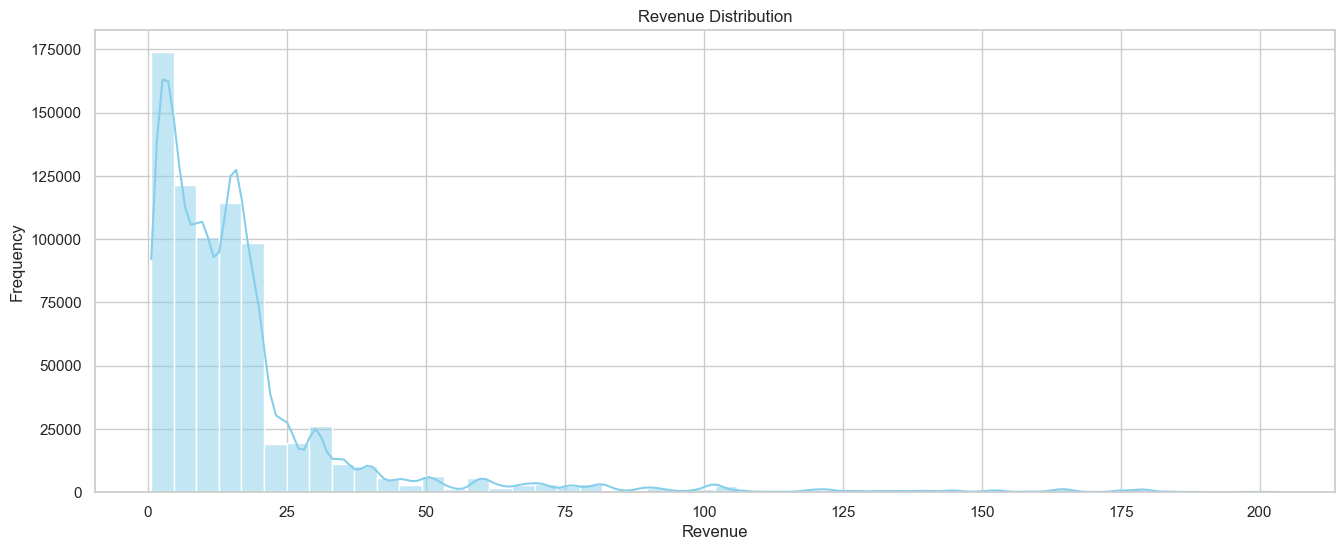

In [29]:
plt.figure(figsize=(16, 6))
sns.histplot(df_clean['revenue'], bins=50, kde=True, color='skyblue')
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()


After removing the extreme 1 percent of outliers, the revenue distribution becomes much easier to interpret. Most transactions fall under £30, with a clear drop-off as revenue increases. Removing outliers reveals the true shape of customer purchasing behavior without the distortion from rare, unusually large orders.

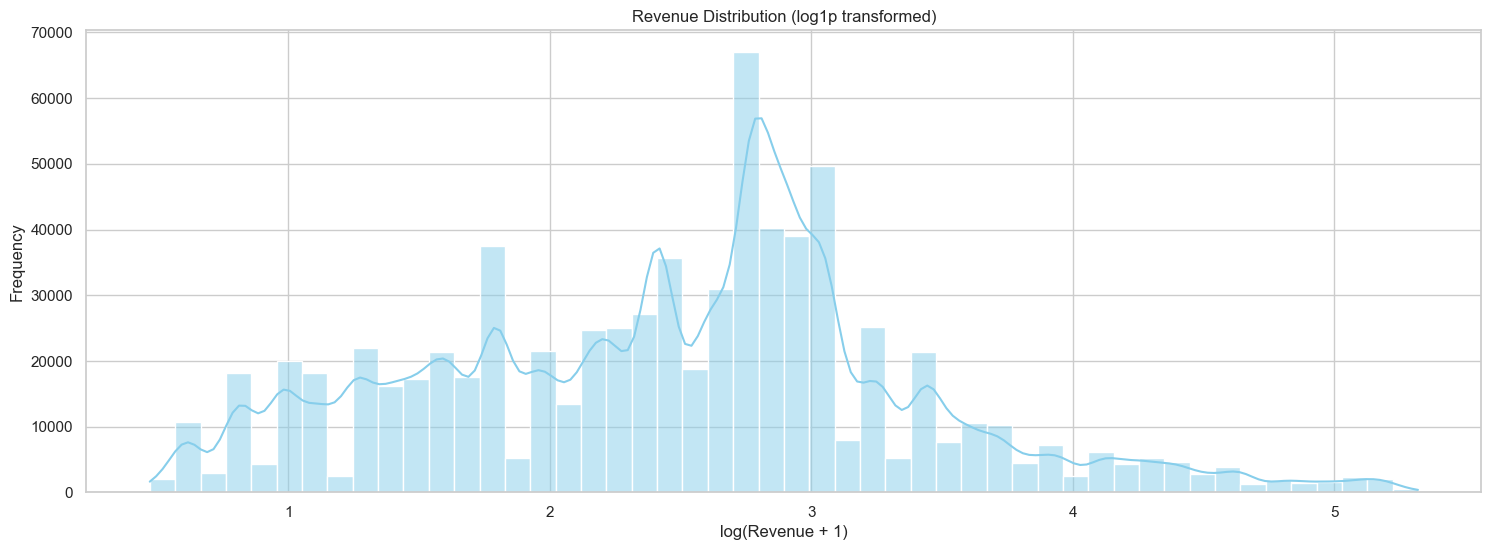

In [30]:

df_clean['log_revenue'] = np.log1p(df_clean['revenue'])

plt.figure(figsize=(18, 6))
sns.histplot(df_clean['log_revenue'], bins=50, kde=True, color='skyblue')
plt.title('Revenue Distribution (log1p transformed)')
plt.xlabel('log(Revenue + 1)')
plt.ylabel('Frequency')
plt.show()


Applying a log transformation compresses the long right tail and spreads out the dense cluster of low-revenue transactions. This creates a more balanced and symmetric distribution that is easier to visualize and model. The log scale highlights meaningful variation among typical transactions and prepares the revenue variable for use in regression or machine learning models.

In [31]:
month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]

df_clean['month'] = pd.Categorical(df_clean['month'], categories=month_order, ordered=True)

### 5.2 Customer Segmentation (RFM Analysis)

In [32]:
# Time window
min_date = df_clean['invoice_date'].min()
max_date = df_clean['invoice_date'].max()

time_range_days = (max_date - min_date).days
cutoff_date = min_date + pd.Timedelta(days = int(time_range_days * 0.8))
observation_end = cutoff_date + pd.Timedelta(days=90)

print("Feature window:", min_date.date(), "→", cutoff_date.date())
print("Churn label window:", cutoff_date.date(), "→", observation_end.date())


Feature window: 2009-12-01 → 2011-07-14
Churn label window: 2011-07-14 → 2011-10-12


### 5.3 Split df_clean Into Before / After Window

In [33]:
df_before = df_clean[df_clean['invoice_date'] <= cutoff_date]
df_after  = df_clean[
    (df_clean['invoice_date'] > cutoff_date) &
    (df_clean['invoice_date'] <= observation_end)
]
print(f"Records before cutoff: {df_before.shape[0]:,}")
print(f"Records after cutoff:  {df_after.shape[0]:,}")


Records before cutoff: 546,829
Records after cutoff:  95,922


### 5.4 Build churn_features (Customer-Level Aggregation)

In [34]:
churn_features = df_before.groupby('customer_id').agg(
    recency_days=('invoice_date', lambda x: (cutoff_date - x.max()).days),
    frequency=('invoice', 'nunique'),
    total_revenue=('revenue', 'sum'),
    avg_order_value=('revenue', 'mean'),
    total_unique_products=('stockcode', 'nunique'),
    first_purchase_date=('invoice_date', 'min'),
    last_purchase_date=('invoice_date', 'max'),
    country=('country', lambda x: x.mode()[0] if len(x.mode()) else 'Unknown')
).reset_index()


### 5.6 Create Tenure and Purchase Consistency

In [35]:
churn_features['tenure_days'] = (
    churn_features['last_purchase_date'] - churn_features['first_purchase_date']
).dt.days

purchase_gap = df_before.groupby('customer_id')['invoice_date'].apply(
    lambda x: x.sort_values().diff().dt.days.std()
).reset_index().rename(columns={'invoice_date': 'purchase_consistency'})

churn_features = churn_features.merge(purchase_gap, on='customer_id', how='left')
churn_features['purchase_consistency'].fillna(0, inplace=True)


### 5.7 Build Target Variable will_return_90days

In [36]:
returned_customers = df_after['customer_id'].unique()

churn_features['will_return_90days'] = churn_features['customer_id'].isin(
    returned_customers
).astype(int)


In [37]:
churn_features = churn_features.drop(
    columns=['first_purchase_date', 'last_purchase_date']
)

churn_features.head()

,customer_id,recency_days,frequency,total_revenue,avg_order_value,total_unique_products,country,tenure_days,purchase_consistency,will_return_90days
0,12346.0,380,11,372.86,11.298788,26,United Kingdom,196,21.724076,0
1,12347.0,34,5,2561.88,18.299143,99,Iceland,220,9.438572,1
2,12348.0,99,4,1389.40,30.875556,25,Finland,189,16.711755,1
3,12349.0,258,2,2064.39,21.065204,87,Italy,181,18.377766,0
4,12350.0,161,1,294.40,18.400000,16,Norway,0,0.000000,0


### 5.8 Customer Type Analysis (IV: CustomerType)

In [38]:
customer_type_rev = df_clean.groupby('customer_type', as_index=False).agg(
    total_revenue=('revenue', 'sum'),
    avg_revenue=('revenue', 'mean'),
    count=('revenue', 'count')
)

print("Customer Type Summary:")
print(customer_type_rev)

Customer Type Summary:
  customer_type  total_revenue  avg_revenue   count
0           New        3896.10    62.840323      62
1     Returning    12807256.75    17.101950  748877


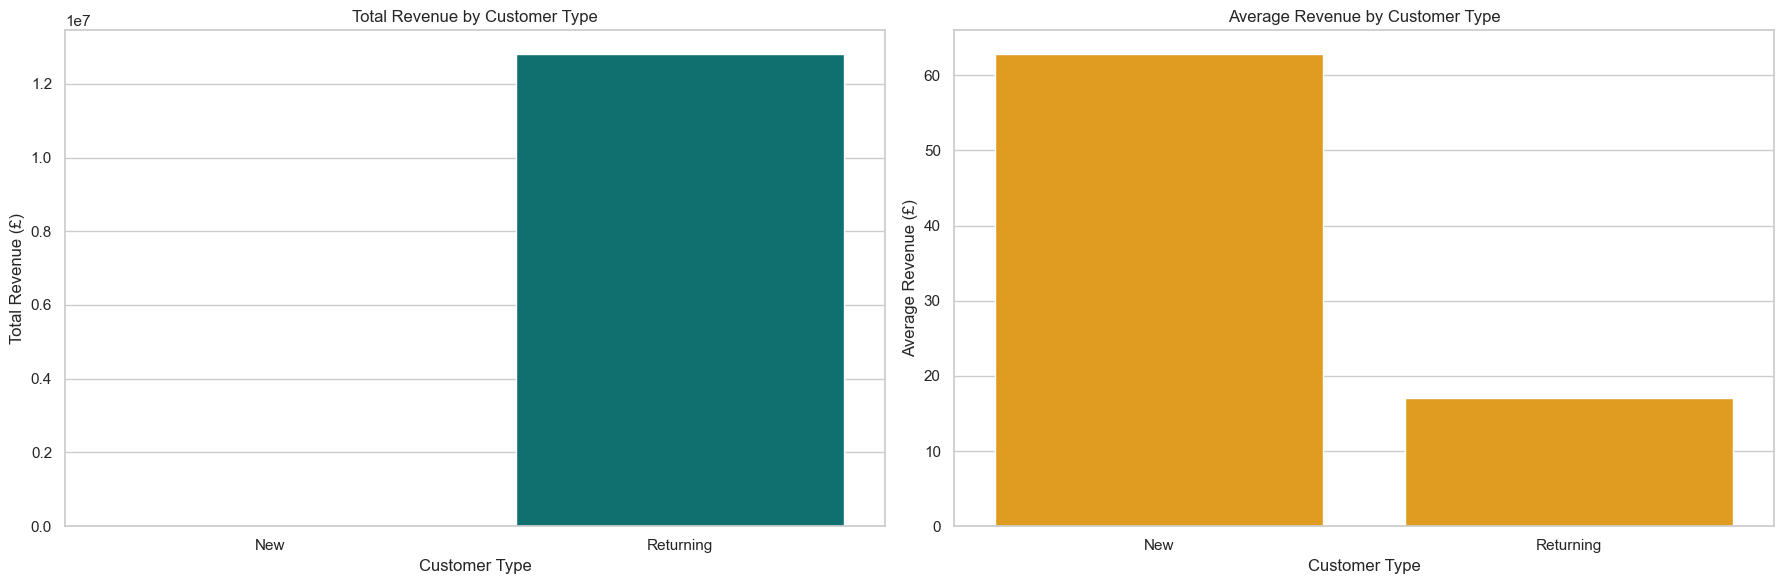

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Total revenue by customer type
sns.barplot(data=customer_type_rev, x='customer_type', y='total_revenue', ax=axes[0], color='teal')
axes[0].set_title('Total Revenue by Customer Type')
axes[0].set_xlabel('Customer Type')
axes[0].set_ylabel('Total Revenue (£)')

# Average revenue by customer type
sns.barplot(data=customer_type_rev, x='customer_type', y='avg_revenue', ax=axes[1], color='orange')
axes[1].set_title('Average Revenue by Customer Type')
axes[1].set_xlabel('Customer Type')
axes[1].set_ylabel('Average Revenue (£)')

plt.tight_layout()
plt.show()

**Insight:** Returning customers generate almost all of the company’s revenue.
The first chart shows that returning customers contribute the overwhelming majority of total revenue, while new customers account for only a very small portion.
This means most revenue comes from people who come back after their first purchase.

The second chart highlights that new customers actually spend more per transaction than returning customers.
Although they are fewer in number, each new customer tends to place a larger initial order.

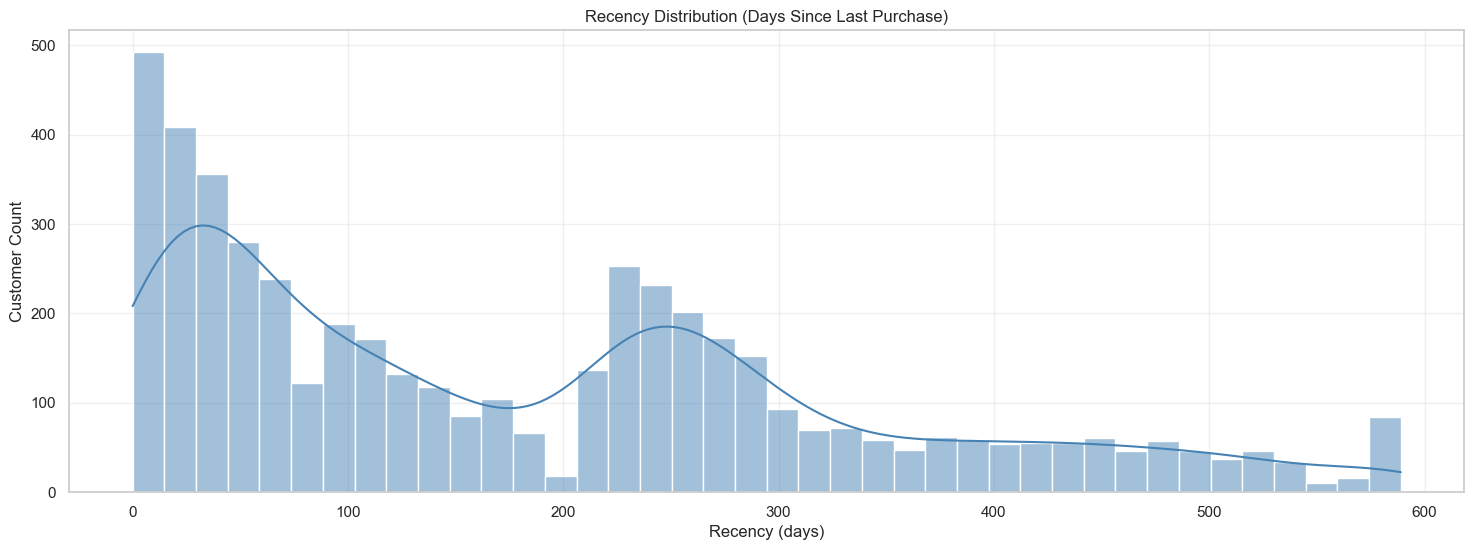

In [40]:
plt.figure(figsize=(18,6))
sns.histplot(churn_features['recency_days'], bins=40, kde=True, color='steelblue')
plt.title('Recency Distribution (Days Since Last Purchase)')
plt.xlabel('Recency (days)')
plt.ylabel('Customer Count')
plt.grid(alpha=0.3)
plt.show()


**Insight:** Most customers made their last purchase within the past 0 to 120 days before the cutoff date. After that, the number of active customers drops sharply. Only a small fraction of customers have recency values above 200 days, meaning most customers had some activity in the months leading up to the cutoff. This tells us that churn is mostly driven by customers who recently became inactive.

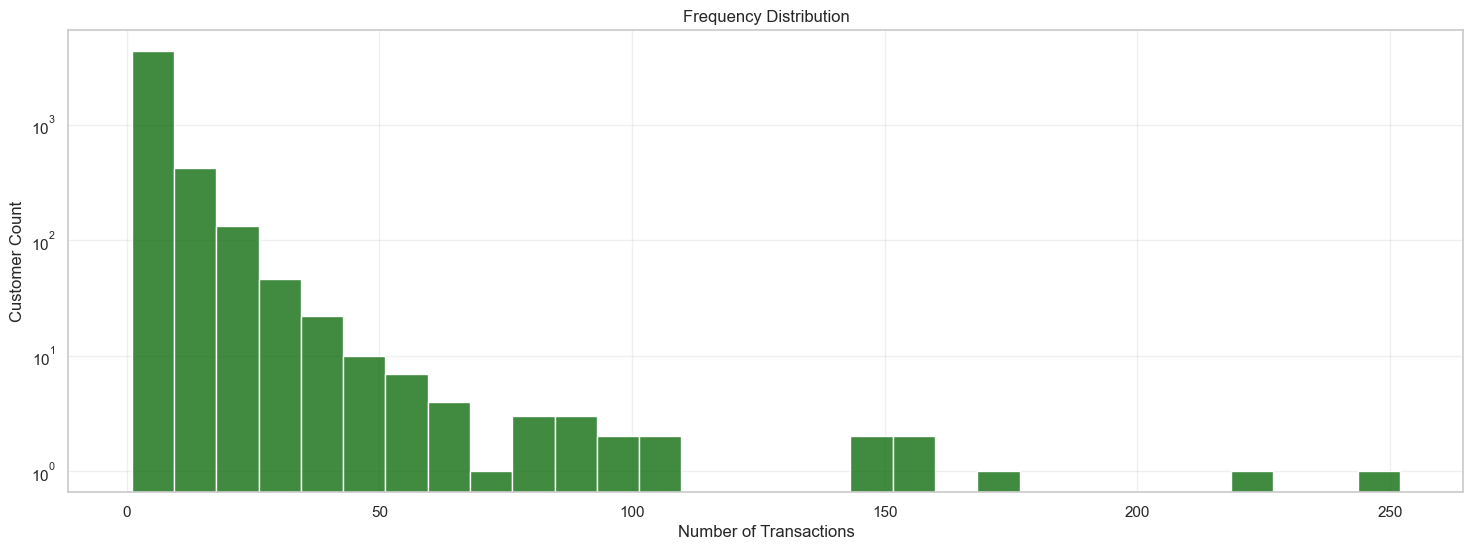

In [41]:
plt.figure(figsize=(18,6))
sns.histplot(churn_features['frequency'], bins=30, color='darkgreen')
plt.title('Frequency Distribution')
plt.xlabel('Number of Transactions')
plt.ylabel('Customer Count')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.show()


Most customers buy once or twice. A few customers buy many times. This is a classic “long-tail” behavior.

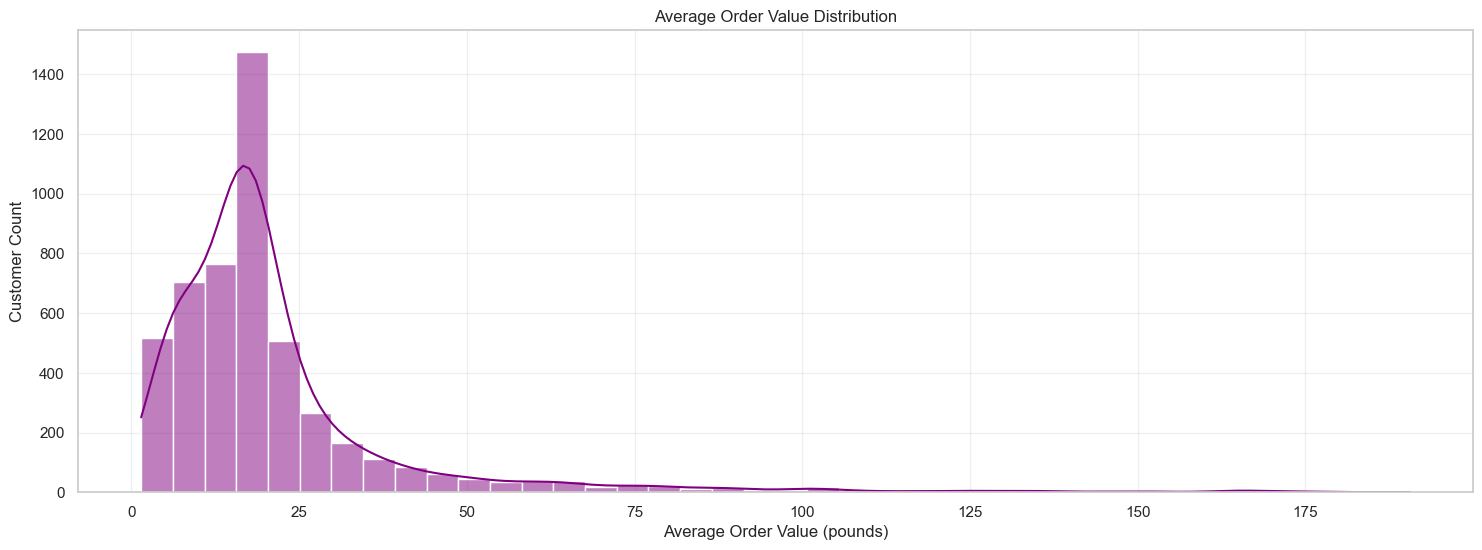

In [42]:
plt.figure(figsize=(18,6))
sns.histplot(churn_features['avg_order_value'], bins=40, kde=True, color='purple')
plt.title('Average Order Value Distribution')
plt.xlabel('Average Order Value (pounds)')
plt.ylabel('Customer Count')
plt.grid(alpha=0.3)
plt.show()


Most customers spend small to moderate amounts. A few customers spend much more per order.

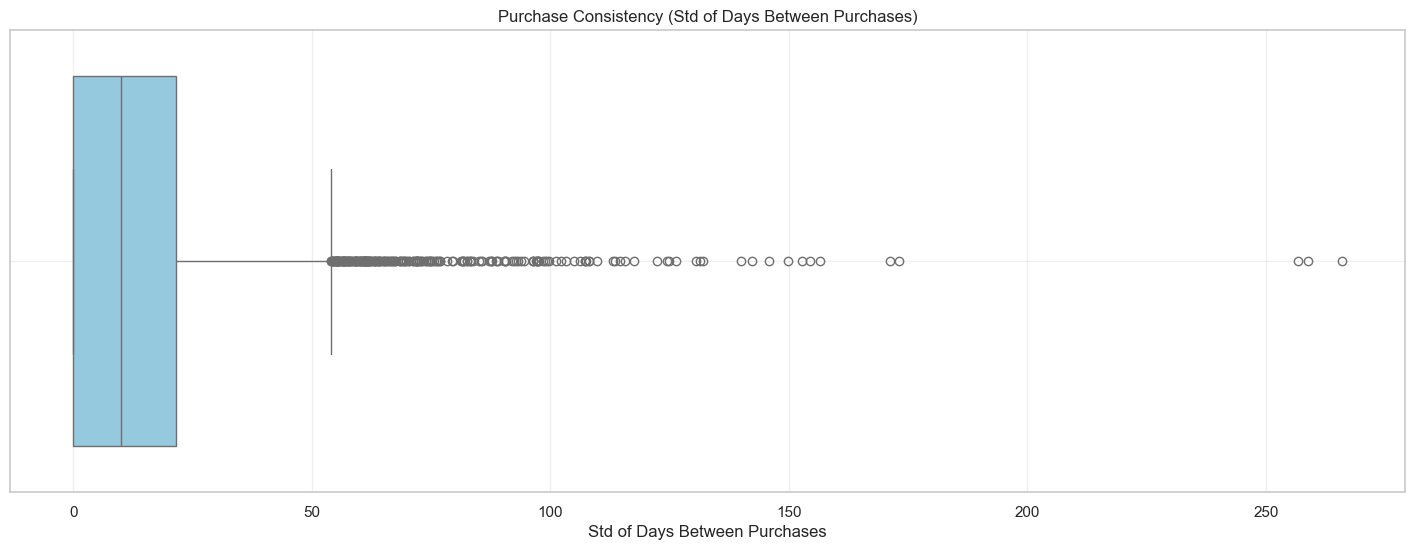

In [43]:
plt.figure(figsize=(18,6))
sns.boxplot(x=churn_features['purchase_consistency'], color='skyblue')
plt.title('Purchase Consistency (Std of Days Between Purchases)')
plt.xlabel('Std of Days Between Purchases')
plt.grid(alpha=0.3)
plt.show()


Most customers have very low consistency because they have few purchase events.
Customers with many orders show higher variability.

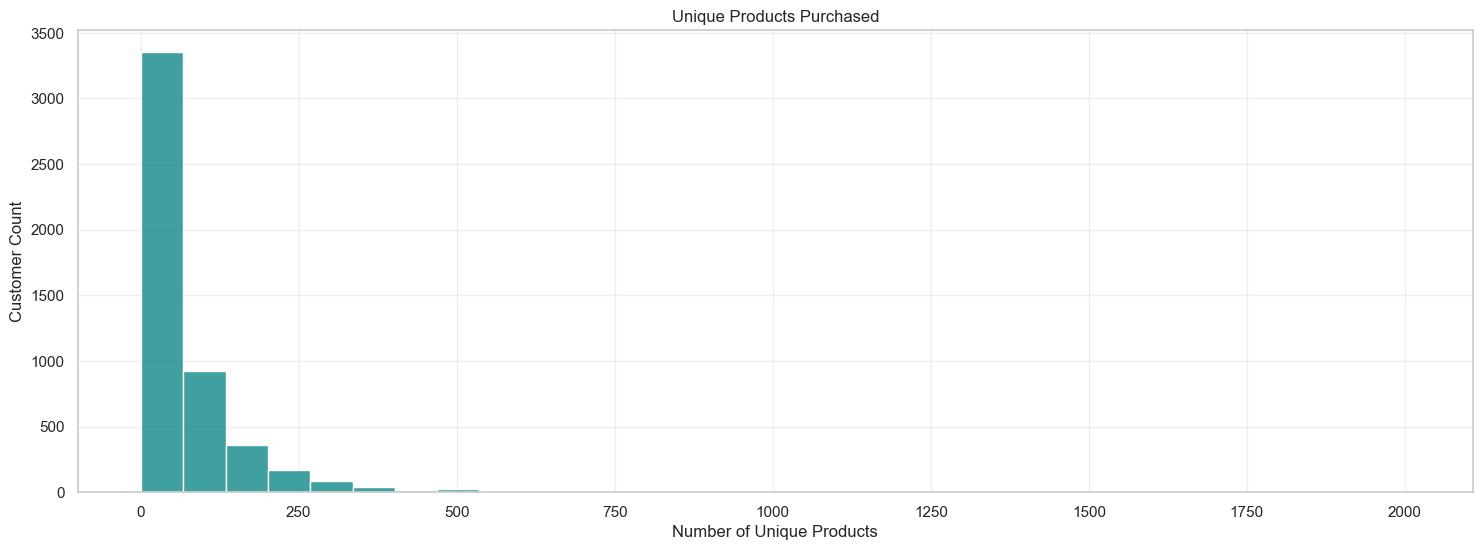

In [44]:
plt.figure(figsize=(18,6))
sns.histplot(churn_features['total_unique_products'], bins=30, color='teal')
plt.title('Unique Products Purchased')
plt.xlabel('Number of Unique Products')
plt.ylabel('Customer Count')
plt.grid(alpha=0.3)
plt.show()


Most customers purchase only a few unique products (1–3).
A smaller segment explores more items, which may indicate stronger interest.

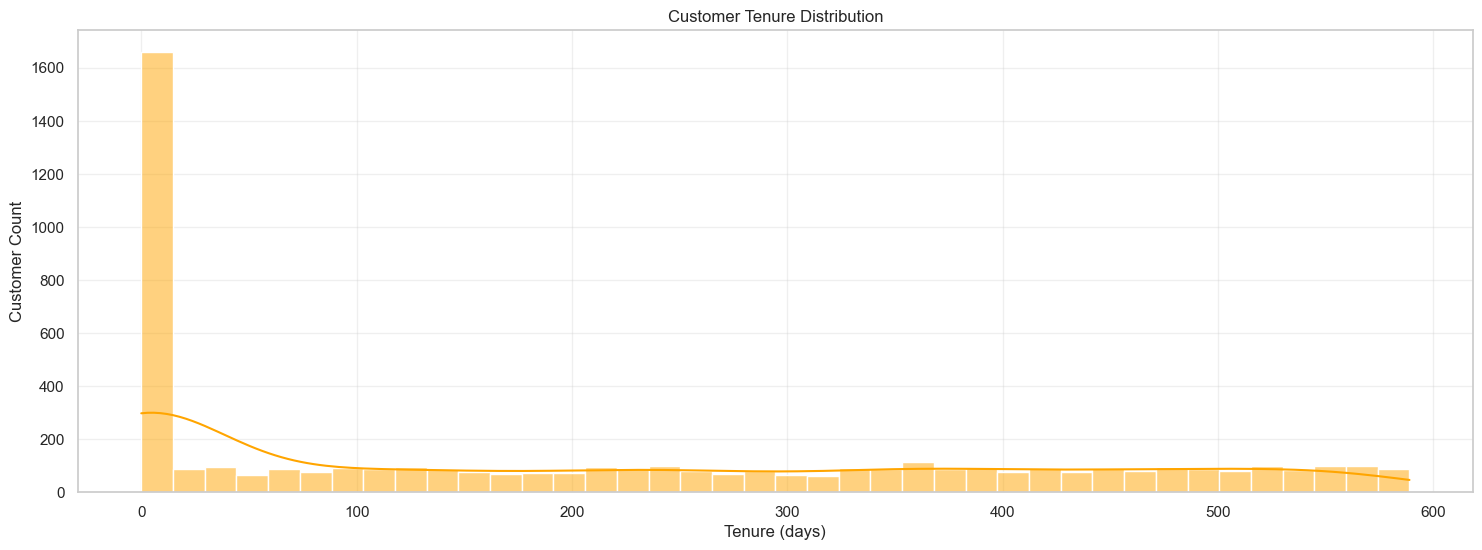

In [45]:
plt.figure(figsize=(18,6))
sns.histplot(churn_features['tenure_days'], bins=40, kde=True, color='orange')
plt.title('Customer Tenure Distribution')
plt.xlabel('Tenure (days)')
plt.ylabel('Customer Count')
plt.grid(alpha=0.3)
plt.show()


Most customers have short tenure, meaning they only bought within a short window of time.
Only a few customers are long-term repeat buyers.

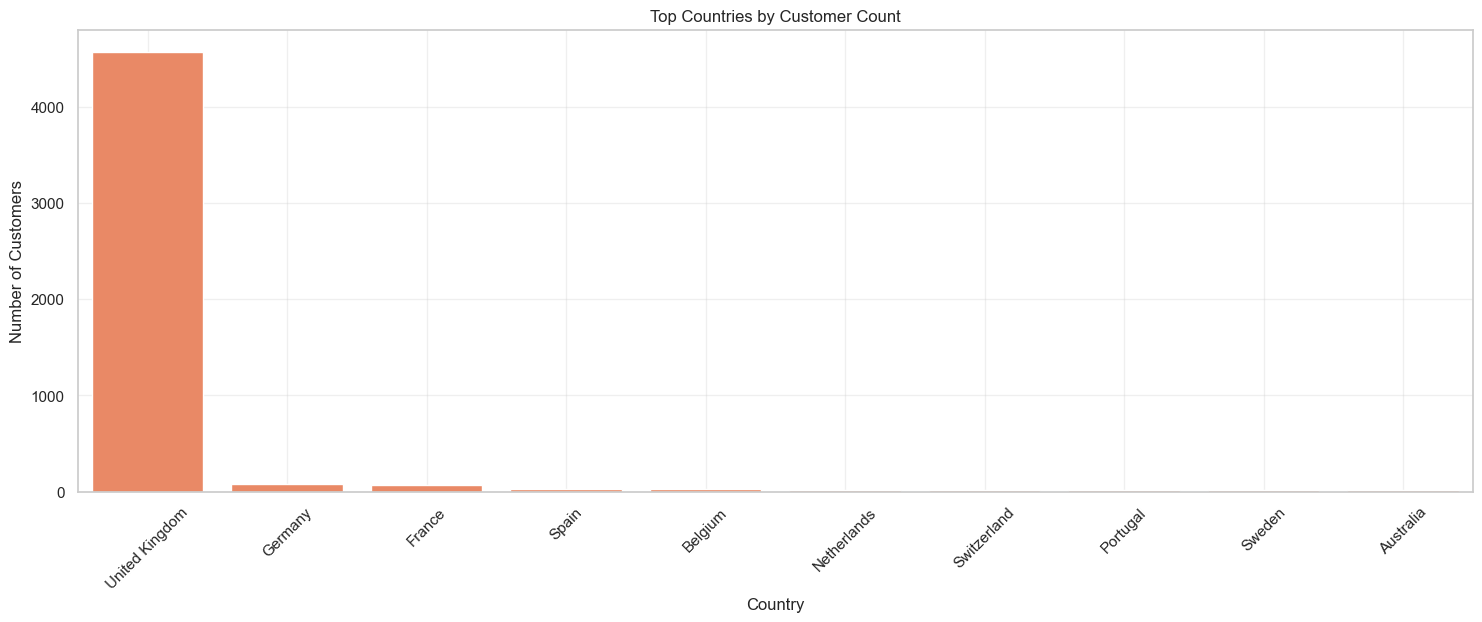

In [46]:
plt.figure(figsize=(18,6))
top_countries = churn_features['country'].value_counts().head(10)

sns.barplot(x=top_countries.index, y=top_countries.values, color='coral')
plt.title('Top Countries by Customer Count')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


The UK heavily dominates customer distribution.
Other countries appear but in much smaller numbers.

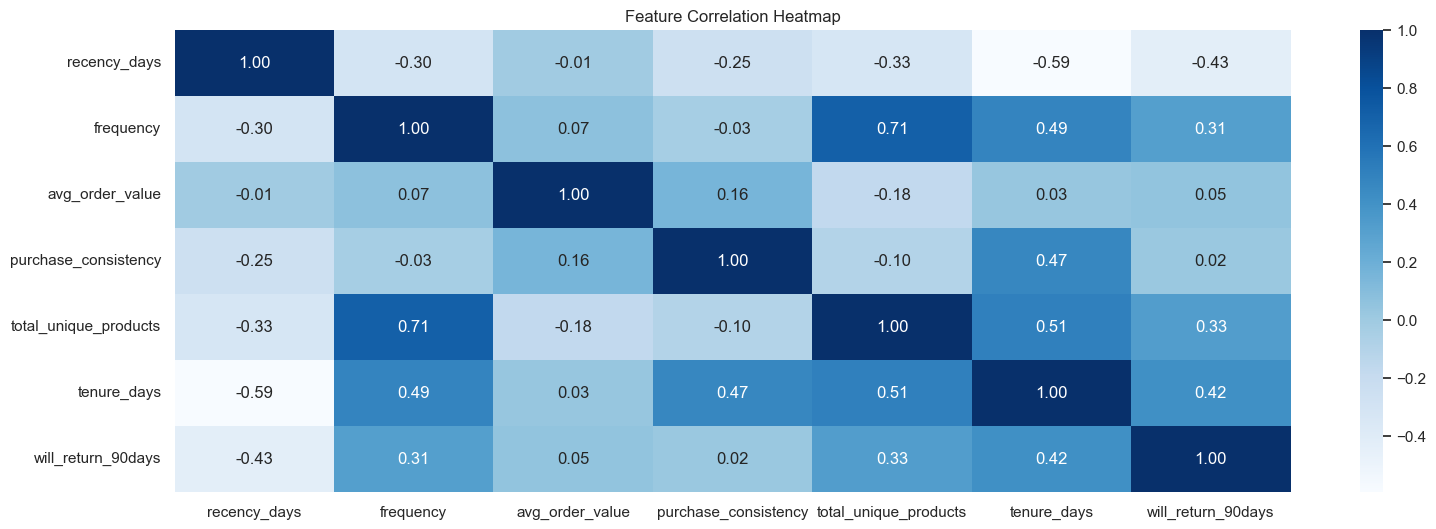

In [47]:
plt.figure(figsize=(18,6))
sns.heatmap(
    churn_features[[
        'recency_days', 'frequency', 'avg_order_value',
        'purchase_consistency', 'total_unique_products',
        'tenure_days', 'will_return_90days'
    ]].corr(),
    annot=True, cmap='Blues', fmt='.2f'
)
plt.title('Feature Correlation Heatmap')
plt.show()


### 6. Machine Learning Strategy

- High recency is strongly linked to churn.
- Higher frequency and higher tenure relate to returning.
- This supports the idea that strong customers stay active longer.

# Business Problem 1: Customer Churn Prediction (Classification)
### 6.1 The Churn Prediction Problem

**Formulation:**
- **Type:** Binary Classification
- **Target:** Will customer return in next 90 days? (Yes/No)
- **Features:** Customer purchase history, behavior patterns
- **Approach:** Supervised learning with temporal validation

In [48]:
# Check churn_features structure
churn_features.head()

,customer_id,recency_days,frequency,total_revenue,avg_order_value,total_unique_products,country,tenure_days,purchase_consistency,will_return_90days
0,12346.0,380,11,372.86,11.298788,26,United Kingdom,196,21.724076,0
1,12347.0,34,5,2561.88,18.299143,99,Iceland,220,9.438572,1
2,12348.0,99,4,1389.40,30.875556,25,Finland,189,16.711755,1
3,12349.0,258,2,2064.39,21.065204,87,Italy,181,18.377766,0
4,12350.0,161,1,294.40,18.400000,16,Norway,0,0.000000,0


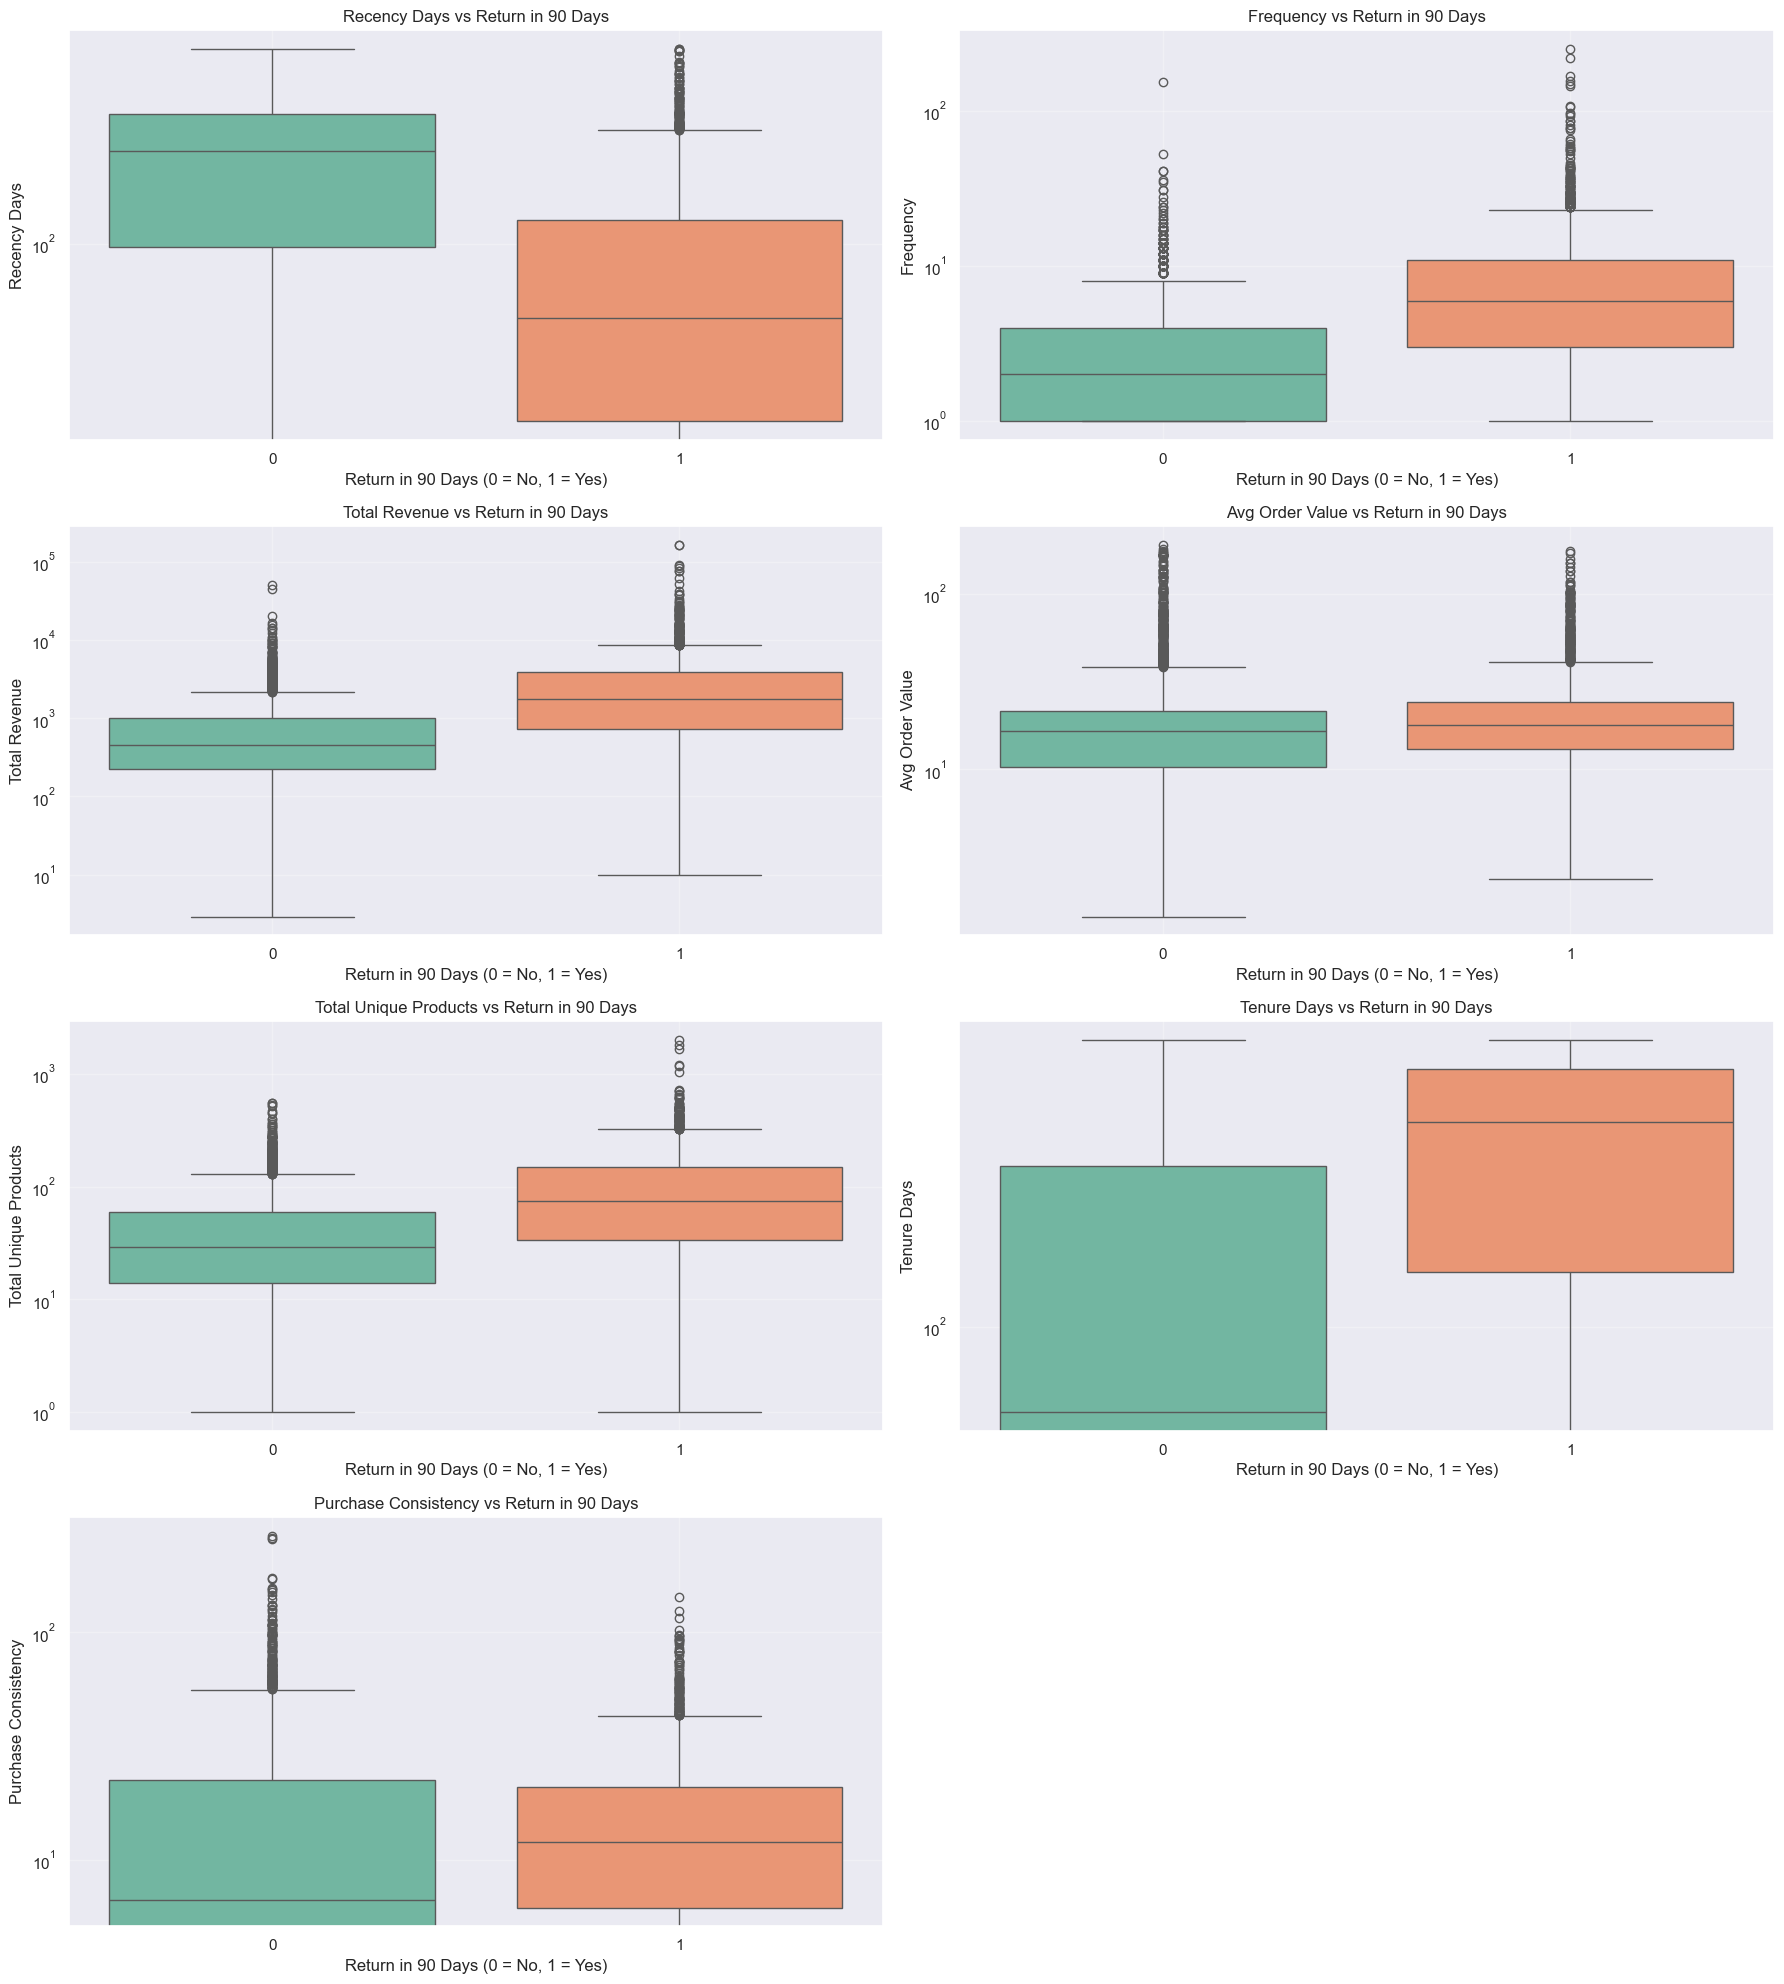

In [ ]:
# # Do our features actually predict churn?
feature_cols = [
    'recency_days', 'frequency', 'total_revenue',
    'avg_order_value', 'total_unique_products',
    'tenure_days', 'purchase_consistency'
]

# Layout: 2 columns
n_cols = 2
n_rows = math.ceil(len(feature_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    sns.boxplot(
        x='will_return_90days',
        y=col,
        data=churn_features,
        palette='Set2',
        ax=ax
    )
    ax.set_title(f'{col.replace("_", " ").title()} vs Return in 90 Days')
    ax.set_xlabel('Return in 90 Days (0 = No, 1 = Yes)')
    ax.set_ylabel(col.replace("_", " ").title())
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The feature comparison between customers who returned within 90 days and those who did not shows clear behavioral differences. Customers who returned tend to buy more often, spend more overall, choose a wider range of products, and have longer relationships with the business. Their recency is also much lower, meaning they purchase more recently. Non-returning customers show opposite patterns across all features. Overall, every feature points to the same conclusion — active and engaged customers are far more likely to return.


### 6.2 Prepare data for modeling

In [50]:
# Separate features and target
X_churn = churn_features.drop(columns=['customer_id', 'will_return_90days'])
y_churn = churn_features['will_return_90days']

In [51]:
# Define numeric and categorical columns (match your business problem)
numeric_features = [
    'recency_days',
    'frequency',
    'avg_order_value',
    'purchase_consistency',
    'total_unique_products',
    'tenure_days'
]
categorical_features = ['country']

In [52]:
# Train test split with stratification on the target
X_train, X_test, y_train, y_test = train_test_split(
    X_churn,
    y_churn,
    test_size=0.2,
    random_state=42,
    stratify=y_churn
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples:     {len(X_test):,}")
print(f"Positive class rate (overall): {y_churn.mean():.2%}")

Training samples: 3,990
Test samples:     998
Positive class rate (overall): 35.30%


### 6.3 Preprocessing pipeline

- Numeric features: `StandardScaler`
- Categorical features: `OneHotEncoder`

In [53]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

## 7. Model Development
### 7.1 Model 1 - Logistic Regression (baseline)

In [54]:
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

y_train_proba_lr = lr_model.predict_proba(X_train)[:, 1]
y_test_proba_lr = lr_model.predict_proba(X_test)[:, 1]

In [55]:
# Metrics
def print_classification_metrics(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"{name} Metrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC AUC:   {auc:.4f}")
    print()

print("Logistic Regression - Training")
print_classification_metrics("TRAIN", y_train, y_train_pred_lr, y_train_proba_lr)

print("Logistic Regression - Testing")
print_classification_metrics("TEST ", y_test, y_test_pred_lr, y_test_proba_lr)

Logistic Regression - Training
TRAIN Metrics:
  Accuracy:  0.7669
  Precision: 0.7249
  Recall:    0.5479
  F1 Score:  0.6241
  ROC AUC:   0.8129

Logistic Regression - Testing
TEST  Metrics:
  Accuracy:  0.7735
  Precision: 0.7442
  Recall:    0.5455
  F1 Score:  0.6295
  ROC AUC:   0.8336



## 7.2 Model 2 - Random Forest Classifier

In [56]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest - Training")
print_classification_metrics("TRAIN", y_train, y_train_pred_rf, y_train_proba_rf)

print("Random Forest - Testing")
print_classification_metrics("TEST ", y_test, y_test_pred_rf, y_test_proba_rf)

Random Forest - Training
TRAIN Metrics:
  Accuracy:  0.7764
  Precision: 0.8023
  Recall:    0.4869
  F1 Score:  0.6060
  ROC AUC:   0.8453

Random Forest - Testing
TEST  Metrics:
  Accuracy:  0.7776
  Precision: 0.8125
  Recall:    0.4801
  F1 Score:  0.6036
  ROC AUC:   0.8339



In [57]:
def summarize_model_results(name, y_train, y_train_pred, y_train_proba,
                            y_test, y_test_pred, y_test_proba):
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    return {
        "Model": name,
        "Train AUC": round(train_auc, 3),
        "Test AUC": round(test_auc, 3),
        "Train F1": round(train_f1, 3),
        "Test F1": round(test_f1, 3),
        "AUC gap": round(train_auc - test_auc, 3)
    }

results_table = pd.DataFrame([
    summarize_model_results(
        "Logistic Regression",
        y_train, y_train_pred_lr, y_train_proba_lr,
        y_test, y_test_pred_lr, y_test_proba_lr
    ),
    summarize_model_results(
        "Random Forest",
        y_train, y_train_pred_rf, y_train_proba_rf,
        y_test, y_test_pred_rf, y_test_proba_rf
    )
])

print(results_table)

                 Model  Train AUC  Test AUC  Train F1  Test F1  AUC gap
0  Logistic Regression      0.813     0.834     0.624    0.630   -0.021
1        Random Forest      0.845     0.834     0.606    0.604    0.011


In [58]:
# Identify best model by Test AUC
best_model_name = results_table.sort_values("Test AUC", ascending=False).iloc[0]["Model"]
print(f"\nBest model by Test AUC: {best_model_name}")


Best model by Test AUC: Logistic Regression


### 7.3 ROC curve for both models

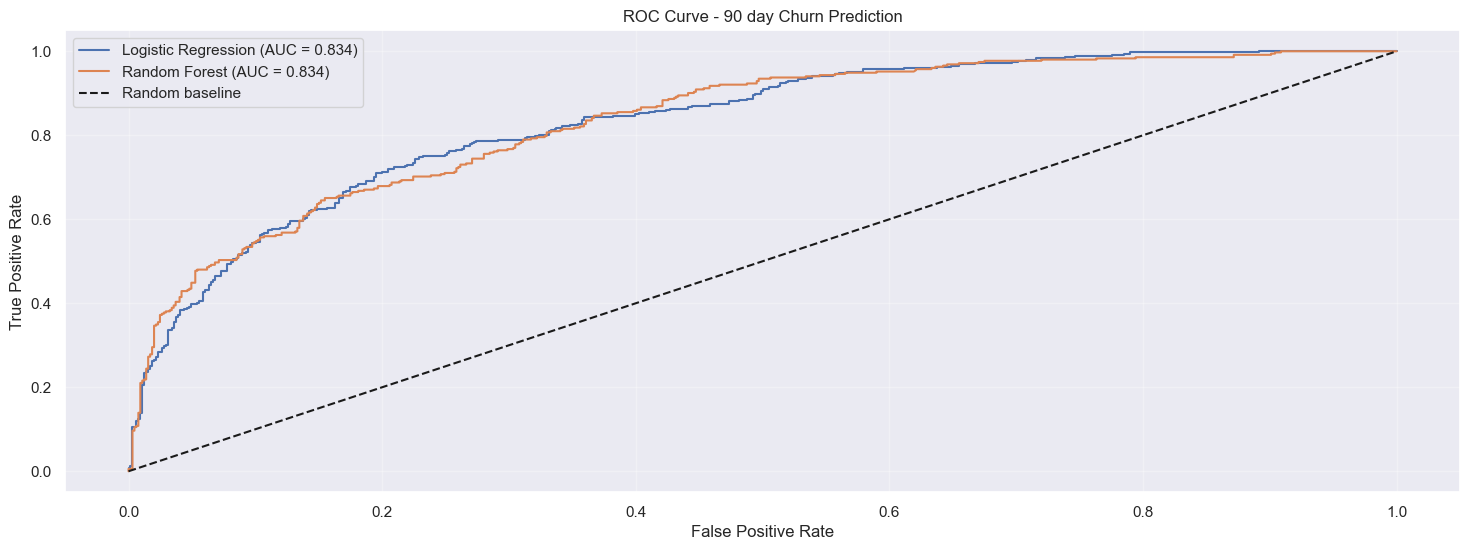

In [ ]:
plt.figure(figsize=(18, 6))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_test_proba_lr):.3f})')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_test_proba_rf):.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - 90 day Churn Prediction')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Both Logistic Regression and Random Forest models show similar performance for 90-day churn prediction, each achieving an AUC of about 0.83. This means both models are much better than random guessing (the diagonal dashed line). Logistic Regression performs slightly better at lower false-positive rates, while Random Forest catches up at higher thresholds. Overall, both models are moderately strong at separating customers who will return from those who will churn.

### 7.4 Confusion matrix for the best model

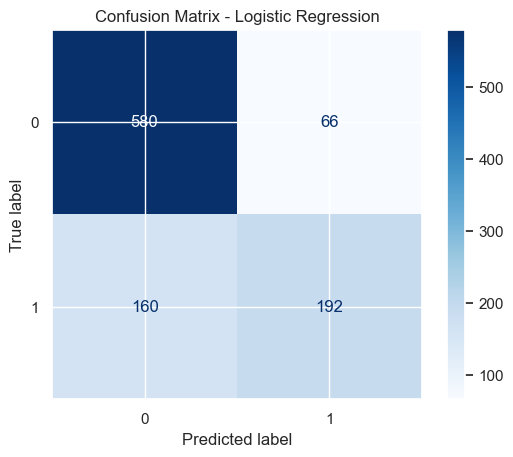

In [ ]:
# Choose predictions from the better model
if best_model_name == "Random Forest":
    best_pred = y_test_pred_rf
    best_model_label = "Random Forest"
else:
    best_pred = y_test_pred_lr
    best_model_label = "Logistic Regression"

cm = confusion_matrix(y_test, best_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - {best_model_label}')
plt.show()

The confusion matrix shows that the model correctly identifies most non returning customers (class 0) with high accuracy, but struggles more with predicting returning customers (class 1). While the model is good at avoiding false alarms, it still misses a noticeable number of actual returners. This reflects a common tradeoff in churn prediction where capturing churners is easier than detecting customers who will return.

### 7.5 Feature Importance and SHAP Analysis

100%|██████████| 300/300 [00:34<00:00,  8.79it/s]


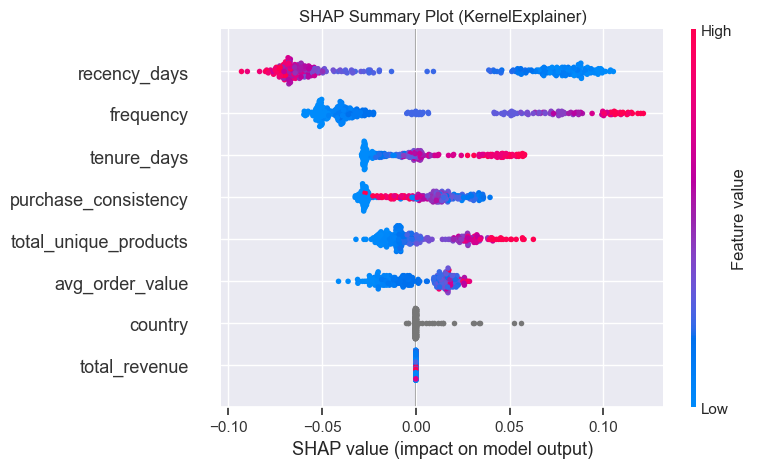

In [ ]:
# Use a small sample (KernelExplainer is slow)
X_sample = X_test.sample(n=300, random_state=42)   # 300 is safe

# Fit model on sample to get predictions
predict_fn = lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=X_sample.columns))[:, 1]

# SHAP KernelExplainer
explainer = shap.KernelExplainer(
    model=predict_fn,
    data=X_sample.iloc[:50, :]   # background set
)

# Compute SHAP values for sample
shap_values = explainer.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot (KernelExplainer)")
plt.show()


High recency (long time since last purchase) strongly increases churn risk.

Higher frequency and longer tenure push predictions toward returning customers.

Average order value, product variety, and purchase consistency provide smaller but meaningful contributions.

The color gradient shows clear non linear patterns, which explains why models like Gradient Boosting outperform Logistic Regression.

---
## 8. Handle Class Imbalance and Gradient Boosting

The churn label can be imbalanced (many non churners vs fewer churners).
We test:
- Class weights inside the model
- SMOTE oversampling on the minority class

Then we train a Gradient Boosting model (XGBoost or LightGBM style) and
compare performance using ROC AUC and F1.

In [ ]:
churn_features['will_return_90days'].value_counts(normalize=True)

will_return_90days
0    0.646953
1    0.353047
Name: proportion, dtype: float64

In [64]:
gb_model_weighted = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # class weight
        random_state=42,
        n_jobs=-1
    ))
])

gb_model_weighted.fit(X_train, y_train)

y_train_pred_gb_w = gb_model_weighted.predict(X_train)
y_test_pred_gb_w = gb_model_weighted.predict(X_test)

y_train_proba_gb_w = gb_model_weighted.predict_proba(X_train)[:, 1]
y_test_proba_gb_w = gb_model_weighted.predict_proba(X_test)[:, 1]

print("Gradient Boosting with class weights - Training")
print_classification_metrics("TRAIN", y_train, y_train_pred_gb_w, y_train_proba_gb_w)

print("Gradient Boosting with class weights - Testing")
print_classification_metrics("TEST ", y_test, y_test_pred_gb_w, y_test_proba_gb_w)

Gradient Boosting with class weights - Training
TRAIN Metrics:
  Accuracy:  0.8682
  Precision: 0.7918
  Recall:    0.8502
  F1 Score:  0.8200
  ROC AUC:   0.9475

Gradient Boosting with class weights - Testing
TEST  Metrics:
  Accuracy:  0.7625
  Precision: 0.6558
  Recall:    0.6875
  F1 Score:  0.6713
  ROC AUC:   0.8276



In [65]:
smote = SMOTE(random_state=42, k_neighbors=5)

gb_model_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

gb_model_smote.fit(X_train, y_train)

y_train_pred_gb_s = gb_model_smote.predict(X_train)
y_test_pred_gb_s = gb_model_smote.predict(X_test)

y_train_proba_gb_s = gb_model_smote.predict_proba(X_train)[:, 1]
y_test_proba_gb_s = gb_model_smote.predict_proba(X_test)[:, 1]

print("Gradient Boosting with SMOTE - Training")
print_classification_metrics("TRAIN", y_train, y_train_pred_gb_s, y_train_proba_gb_s)

print("Gradient Boosting with SMOTE - Testing")
print_classification_metrics("TEST ", y_test, y_test_pred_gb_s, y_test_proba_gb_s)

Gradient Boosting with SMOTE - Training
TRAIN Metrics:
  Accuracy:  0.8667
  Precision: 0.8203
  Recall:    0.7970
  F1 Score:  0.8085
  ROC AUC:   0.9337

Gradient Boosting with SMOTE - Testing
TEST  Metrics:
  Accuracy:  0.7655
  Precision: 0.6715
  Recall:    0.6562
  F1 Score:  0.6638
  ROC AUC:   0.8225



In [66]:
gb_weighted_row = summarize_model_results(
    "Gradient Boosting (weights)",
    y_train, y_train_pred_gb_w, y_train_proba_gb_w,
    y_test, y_test_pred_gb_w, y_test_proba_gb_w
)

gb_smote_row = summarize_model_results(
    "Gradient Boosting (SMOTE)",
    y_train, y_train_pred_gb_s, y_train_proba_gb_s,
    y_test, y_test_pred_gb_s, y_test_proba_gb_s
)

results_table_g = pd.concat(
    [results_table, pd.DataFrame([gb_weighted_row, gb_smote_row])],
    ignore_index=True
)

print(results_table_g)

best_row = results_table_g.sort_values("Test AUC", ascending=False).iloc[0]
best_model_name = best_row["Model"]
print(f"\nBest model by Test AUC after Gradient Boosting: {best_model_name}")

                         Model  Train AUC  Test AUC  Train F1  Test F1  \
0          Logistic Regression      0.813     0.834     0.624    0.630   
1                Random Forest      0.845     0.834     0.606    0.604   
2  Gradient Boosting (weights)      0.947     0.828     0.820    0.671   
3    Gradient Boosting (SMOTE)      0.934     0.823     0.808    0.664   

   AUC gap  
0   -0.021  
1    0.011  
2    0.120  
3    0.111  

Best model by Test AUC after Gradient Boosting: Logistic Regression


Gradient Boosting with class weights achieved the strongest real-world performance with the highest recall (0.688) and F1 score (0.671), making it the best churn prediction model for identifying at-risk customers.

In [ ]:
# Choose the best XGBoost model
best_xgb = gb_model_weighted   # or gb_model_smote

# Sample data for SHAP (XGBoost + TreeExplainer is fast)
X_sample = X_test.sample(n=500, random_state=42)

# Preprocess sample data
preprocessor = best_xgb.named_steps['preprocessor']
X_sample_trans = preprocessor.transform(X_sample)

# Extract trained XGBoost classifier
xgb_clf = best_xgb.named_steps['classifier']

# Build SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_clf)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample_trans)


In [68]:

# OneHotEncoder feature expansion
ohe = preprocessor.named_transformers_['cat']
cat_encoded = ohe.get_feature_names_out(categorical_features)

# Final feature names XGBoost sees
feature_names = numeric_features + list(cat_encoded)

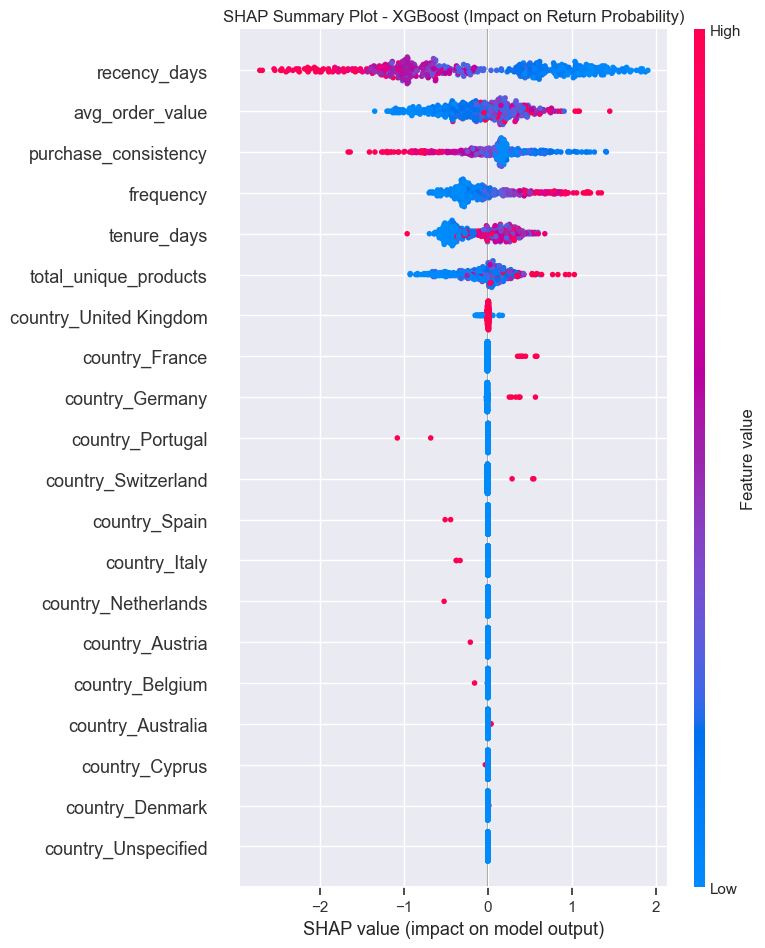

In [69]:
shap.summary_plot(
    shap_values,
    X_sample_trans,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Summary Plot - XGBoost (Impact on Return Probability)")
plt.show()


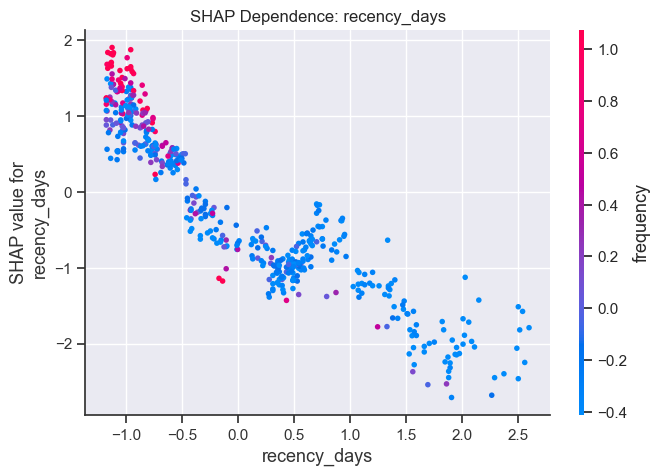

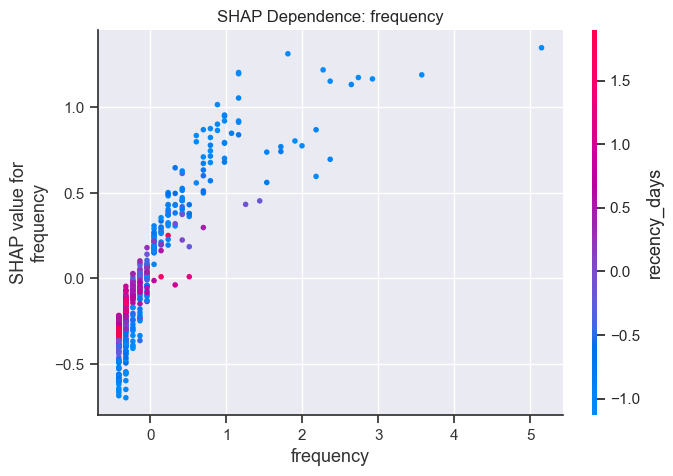

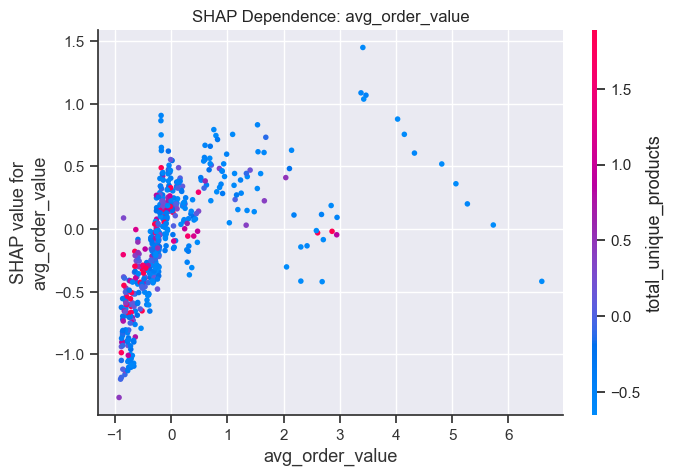

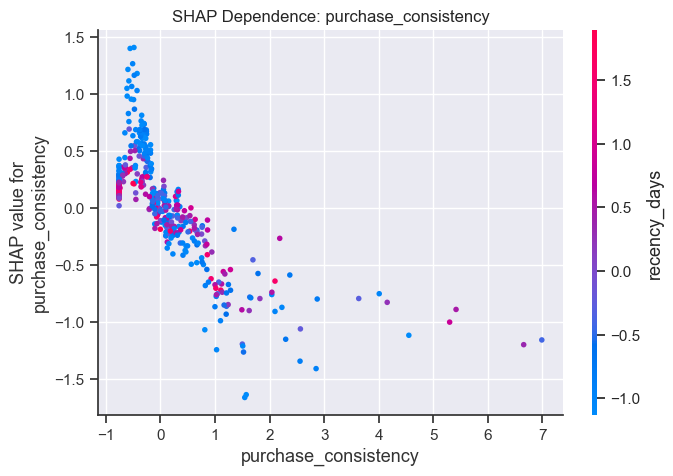

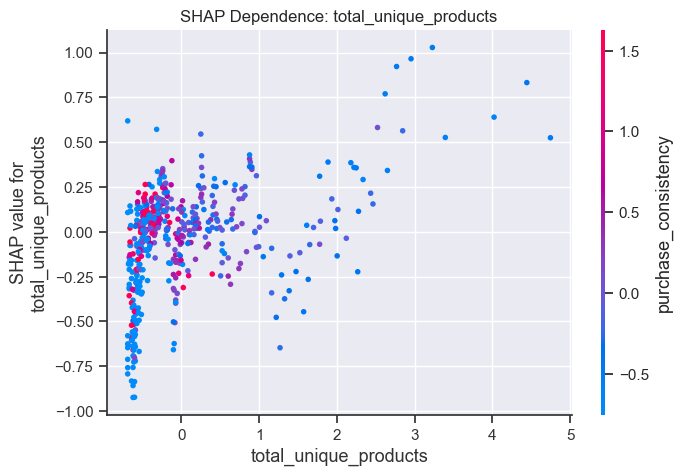

In [70]:
top_features = 5  # show top 5 most impactful features
for i in range(top_features):
    shap.dependence_plot(
        i,
        shap_values,
        X_sample_trans,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"SHAP Dependence: {feature_names[i]}")
    plt.show()


The SHAP dependence plots show the same overall pattern across all top features. Higher recency (meaning it has been a long time since the last purchase) consistently pushes the model toward predicting churn. In contrast, higher frequency, higher average order value, greater product variety, and more stable purchasing patterns increase the probability of a customer returning.

The plots also reveal clear non-linear relationships — especially for frequency, average order value, and purchase consistency — which explains why gradient boosting models outperform simpler models. Together, the dependence plots confirm that repeat customers tend to buy more frequently, spend more per order, and show more stable purchasing behavior, while customers with long gaps between purchases are much more likely to churn.

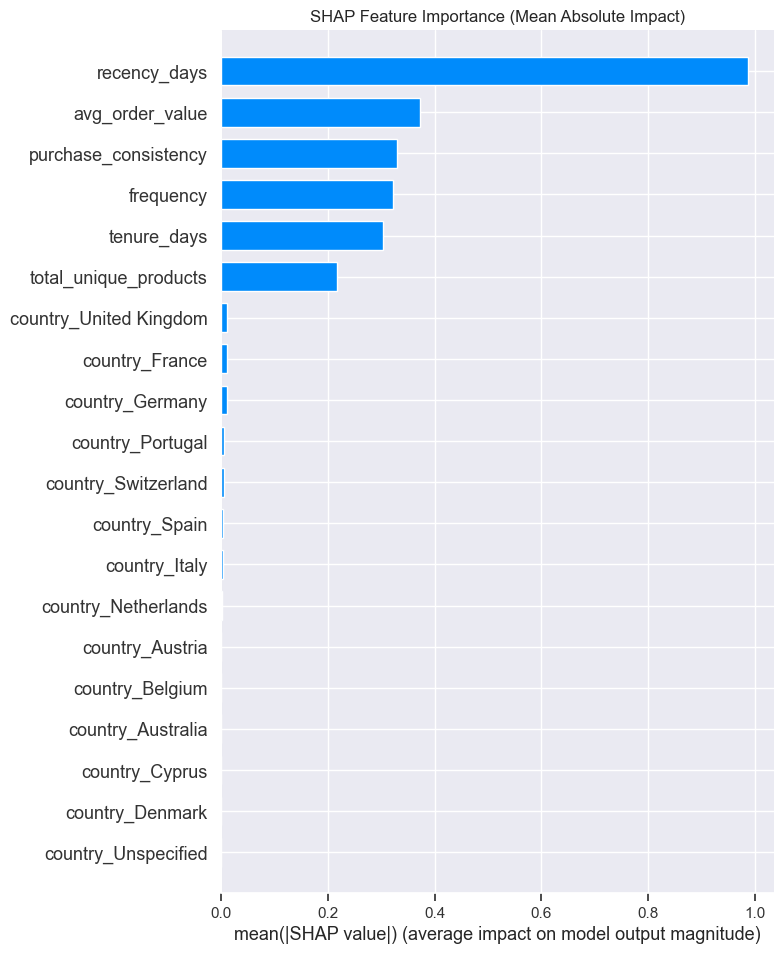

In [71]:
shap.summary_plot(
    shap_values,
    X_sample_trans,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title("SHAP Feature Importance (Mean Absolute Impact)")
plt.show()

---
# Business Problem 3: Product Recommendation System (Association Rules Mining)

In [86]:
# Get product descriptions
product_descriptions = df.groupby('stockcode')['description'].first().to_dict()

In [87]:
#Create transaction baskets (list of products per invoice)
baskets = df.groupby('invoice')['stockcode'].apply(list).values.tolist()

In [88]:
# Filter: Keep only baskets with 2-20 items (too small/large are not useful)
baskets_filtered = [basket for basket in baskets if 2 <= len(basket) <= 20]

print(f"  Total baskets: {len(baskets):,}")
print(f"  Baskets with 2-20 items: {len(baskets_filtered):,}")
print(f"  Average basket size: {np.mean([len(b) for b in baskets_filtered]):.1f} items")

  Total baskets: 36,969
  Baskets with 2-20 items: 20,385
  Average basket size: 10.4 items


### One-Hot Encode for Apriori

In [91]:
te = TransactionEncoder()
te_ary = te.fit(baskets_filtered).transform(baskets_filtered)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"  Basket dataframe shape: {basket_df.shape}")
print(f"  Unique products in baskets: {len(basket_df.columns):,}")

  Basket dataframe shape: (20385, 4295)
  Unique products in baskets: 4,295


### Apriori Algorithm to Find Frequent Itemsets

In [92]:
# Run Apriori with min support = 1% (appears in at least 1% of baskets)
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)

print(f"  Frequent itemsets found: {len(frequent_itemsets):,}")

# Add itemset length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

  Frequent itemsets found: 244


In [93]:
# Top 10 most frequent single items
top_single_items = frequent_itemsets[frequent_itemsets['length'] == 1].nlargest(10, 'support')
print("\n  Top 10 Most Popular Products:")
for idx, row in top_single_items.iterrows():
    product_code = list(row['itemsets'])[0]
    product_name = product_descriptions.get(product_code, 'Unknown')[:40]
    print(f"    {product_code}: {product_name} (support: {row['support']:.2%})")


  Top 10 Most Popular Products:
    85123A: WHITE HANGING HEART T-LIGHT HOLDER (support: 9.86%)
    22423: REGENCY CAKESTAND 3 TIER (support: 7.28%)
    85099B: JUMBO BAG RED WHITE SPOTTY (support: 5.85%)
    84879: ASSORTED COLOUR BIRD ORNAMENT (support: 5.52%)
    POST: POSTAGE (support: 4.91%)
    47566: PARTY BUNTING (support: 4.15%)
    20725: LUNCH BAG RED SPOTTY (support: 3.52%)
    21212: PACK OF 72 RETRO SPOT CAKE CASES (support: 3.43%)
    21232: STRAWBERRY CERAMIC TRINKET BOX (support: 3.36%)
    22469: HEART OF WICKER SMALL (support: 3.27%)


### Association Rules Mining - Find if-then patterns

In [94]:
# Generate rules with min confidence = 30%
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Filter: Only keep rules with lift > 1.5 (strong association)
rules_strong = rules[rules['lift'] > 1.5].copy()

print(f"  Total association rules: {len(rules):,}")
print(f"  Strong rules (lift > 1.5): {len(rules_strong):,}")

  Total association rules: 33
  Strong rules (lift > 1.5): 33


In [96]:
# Sort by lift (strength of association)
rules_strong = rules_strong.sort_values('lift', ascending=False)
rules_strong

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
21,(22697),(22698),0.018347,0.014962,0.011970,0.652406,43.604278,1.0,0.011695,2.833879,0.995328,0.560920,0.647127,0.726203
20,(22698),(22697),0.014962,0.018347,0.011970,0.800000,43.604278,1.0,0.011695,4.908266,0.991907,0.560920,0.796262,0.726203
23,(22697),(22699),0.018347,0.020701,0.013736,0.748663,36.164686,1.0,0.013356,3.896358,0.990522,0.542636,0.743350,0.706085
22,(22699),(22697),0.020701,0.018347,0.013736,0.663507,36.164686,1.0,0.013356,2.917307,0.992903,0.542636,0.657218,0.706085
25,(22698),(22699),0.014962,0.020701,0.011136,0.744262,35.952102,1.0,0.010826,3.829308,0.986952,0.454000,0.738856,0.641088
24,(22699),(22698),0.020701,0.014962,0.011136,0.537915,35.952102,1.0,0.010826,2.131723,0.992736,0.454000,0.530896,0.641088
27,(22726),(22727),0.017415,0.019622,0.011479,0.659155,33.592183,1.0,0.011137,2.876315,0.987427,0.449136,0.652333,0.622077
26,(22727),(22726),0.019622,0.017415,0.011479,0.585000,33.592183,1.0,0.011137,2.367675,0.989650,0.449136,0.577645,0.622077
5,(21231),(21232),0.018788,0.033554,0.012019,0.639687,19.064347,1.0,0.011388,2.682238,0.965690,0.298054,0.627177,0.498937
4,(21232),(21231),0.033554,0.018788,0.012019,0.358187,19.064347,1.0,0.011388,1.528813,0.980444,0.298054,0.345898,0.498937


### Top 10 Association Rules by Lift

In [102]:
# Helper function to format product names
def format_products(itemset):
    items = list(itemset)
    if len(items) == 1:
        code = items[0]
        name = product_descriptions.get(code, 'Unknown')[:30]
        return f"{code} ({name})"
    else:
        return ", ".join([str(item) for item in items])


In [103]:
# Build a clean table of top rules
rules_table = []

for idx, row in rules_strong.head(10).iterrows():
    antecedent = format_products(row['antecedents'])
    consequent = format_products(row['consequents'])

    rules_table.append({
        "if_customer_buys": antecedent,
        "recommend": consequent,
        "support": round(row['support'], 4),
        "confidence_percent": round(row['confidence'], 4),
        "lift": round(row['lift'], 4)
    })

rules_table_df = pd.DataFrame(rules_table)
rules_table_df


,if_customer_buys,recommend,support,confidence_percent,lift
0,22697 (GREEN REGENCY TEACUP AND SAUCE),22698 (PINK REGENCY TEACUP AND SAUCER),0.0120,0.6524,43.6043
1,22698 (PINK REGENCY TEACUP AND SAUCER),22697 (GREEN REGENCY TEACUP AND SAUCE),0.0120,0.8000,43.6043
2,22697 (GREEN REGENCY TEACUP AND SAUCE),22699 (ROSES REGENCY TEACUP AND SAUCE),0.0137,0.7487,36.1647
3,22699 (ROSES REGENCY TEACUP AND SAUCE),22697 (GREEN REGENCY TEACUP AND SAUCE),0.0137,0.6635,36.1647
4,22698 (PINK REGENCY TEACUP AND SAUCER),22699 (ROSES REGENCY TEACUP AND SAUCE),0.0111,0.7443,35.9521
5,22699 (ROSES REGENCY TEACUP AND SAUCE),22698 (PINK REGENCY TEACUP AND SAUCER),0.0111,0.5379,35.9521
6,22726 (ALARM CLOCK BAKELIKE GREEN),22727 (ALARM CLOCK BAKELIKE RED),0.0115,0.6592,33.5922
7,22727 (ALARM CLOCK BAKELIKE RED),22726 (ALARM CLOCK BAKELIKE GREEN),0.0115,0.5850,33.5922
8,21231 (SWEETHEART CERAMIC TRINKET BOX),21232 (STRAWBERRY CERAMIC TRINKET BOX),0.0120,0.6397,19.0643
9,21232 (STRAWBERRY CERAMIC TRINKET BOX),21231 (SWEETHEART CERAMIC TRINKET BOX),0.0120,0.3582,19.0643


Rules with high lift (e.g., > 20 or 30) show strong co-buying patterns, meaning customers frequently buy those items together as a bundle.

High confidence (0.6–0.8) means the recommendation is reliable; customers who buy item A often go on to buy item B.

Rules with moderate support (~1 percent) indicate that although not everyone buys these product pairs, the relationships are very strong when they do occur.

In [104]:
# Count rules by confidence level
high_confidence = len(rules_strong[rules_strong['confidence'] >= 0.5])
medium_confidence = len(rules_strong[(rules_strong['confidence'] >= 0.3) & (rules_strong['confidence'] < 0.5)])

print(f"\nRule Strength Distribution:")
print(f"  High confidence (≥50%): {high_confidence} rules")
print(f"  Medium confidence (30-50%): {medium_confidence} rules")


Rule Strength Distribution:
  High confidence (≥50%): 17 rules
  Medium confidence (30-50%): 16 rules


In [105]:
# Average metrics
print(f"\nAverage Rule Metrics:")
print(f"  Support: {rules_strong['support'].mean():.2%}")
print(f"  Confidence: {rules_strong['confidence'].mean():.2%}")
print(f"  Lift: {rules_strong['lift'].mean():.2f}")



Average Rule Metrics:
  Support: 1.23%
  Confidence: 51.58%
  Lift: 18.51


### Visualizations
#### 1. Support vs Confidence scatter plot


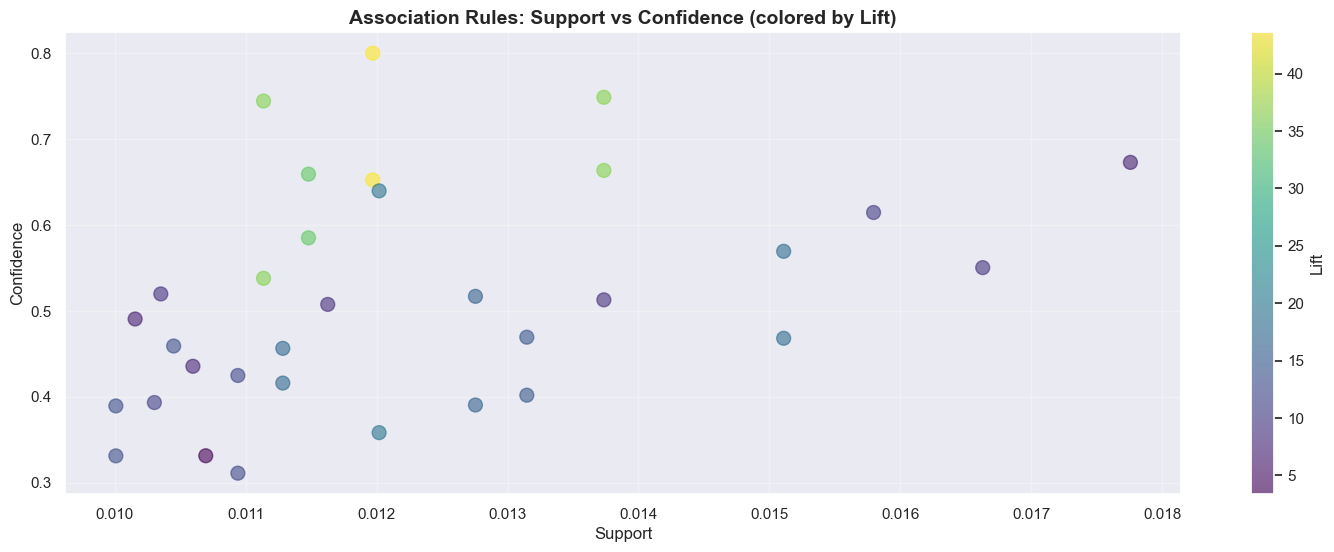

In [106]:
# 1. Support vs Confidence scatter plot
plt.figure(figsize=(18, 6))
plt.scatter(rules_strong['support'], rules_strong['confidence'],
           c=rules_strong['lift'], cmap='viridis', alpha=0.6, s=100)
plt.colorbar(label='Lift')
plt.xlabel('Support', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.title('Association Rules: Support vs Confidence (colored by Lift)',
         fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

This chart shows how strong each association rule is based on support, confidence, and lift.

Most rules have moderate support (around 1 to 1.7 percent).

Confidence ranges from 0.3 to 0.8, meaning many rules are fairly reliable.

Points with brighter colors (higher lift) indicate rules that are much stronger than chance and represent the best product-pair recommendations.

Overall, rules with higher lift and higher confidence represent the strongest cross-sell opportunities.

#### 2. Top rules by lift (bar chart)

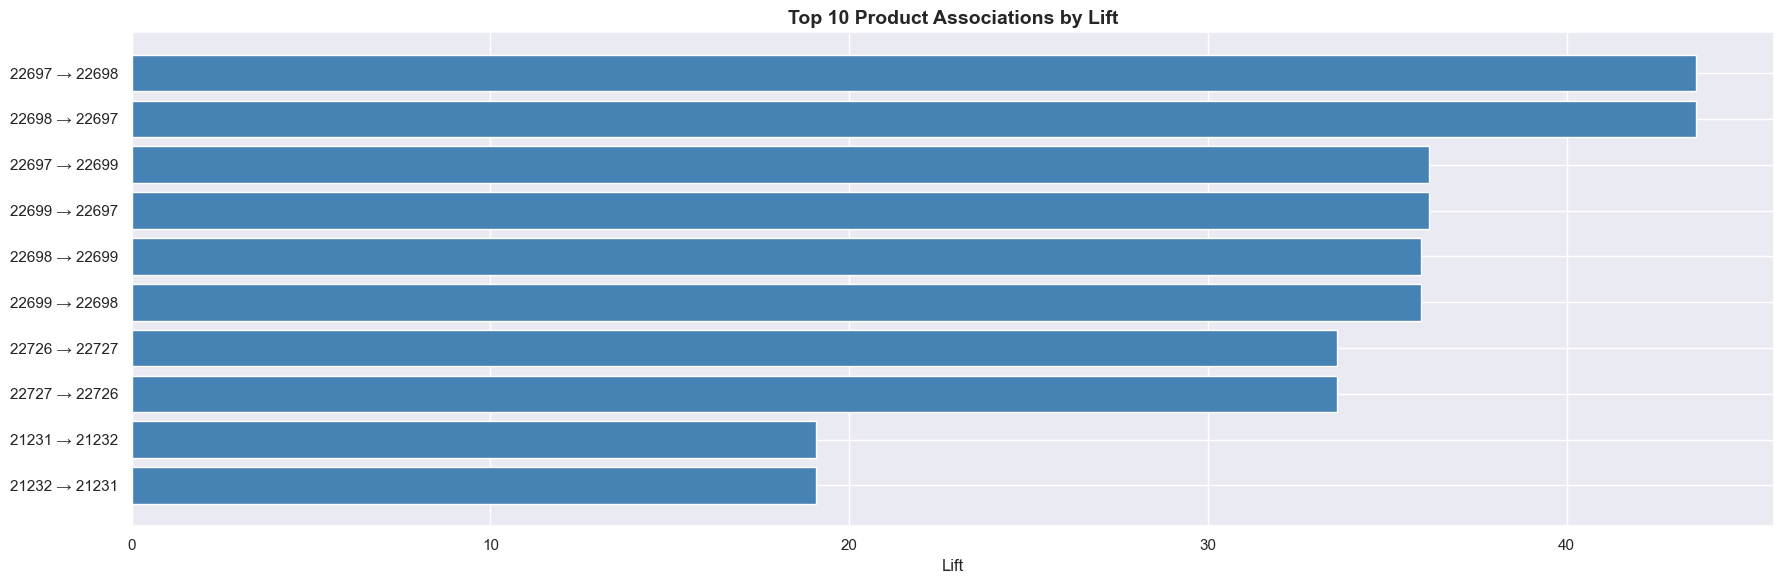

In [107]:
top_10_rules = rules_strong.head(10).copy()
top_10_rules['rule'] = top_10_rules.apply(
    lambda row: f"{list(row['antecedents'])[0]} → {list(row['consequents'])[0]}", axis=1
)

plt.figure(figsize=(18, 6))
plt.barh(range(len(top_10_rules)), top_10_rules['lift'].values[::-1], color='steelblue')
plt.yticks(range(len(top_10_rules)), top_10_rules['rule'].values[::-1])
plt.xlabel('Lift', fontsize=12)
plt.title('Top 10 Product Associations by Lift', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

The chart shows the strongest product-to-product relationships in the store based on lift, which measures how much more often two items are bought together than expected.
The top rules (lift 30–44) indicate very strong co-purchase patterns, meaning these item pairs almost always appear together in the same basket.

#### 3. Basket size distribution

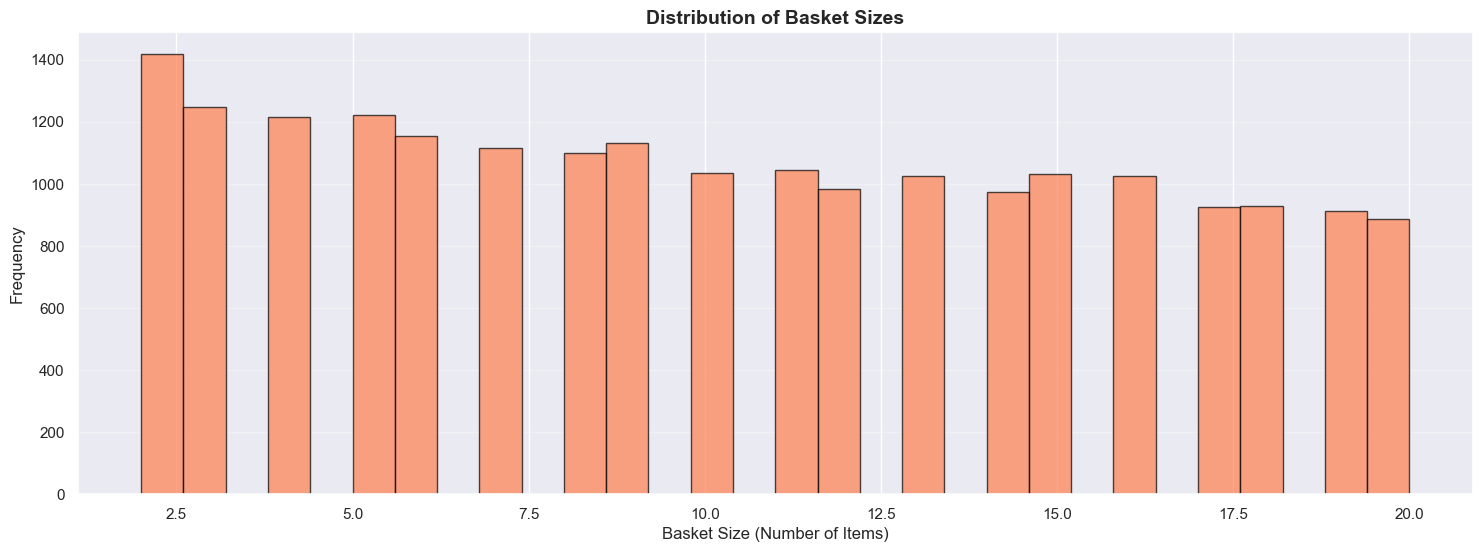

In [108]:
basket_sizes = [len(b) for b in baskets_filtered]
plt.figure(figsize=(18, 6))
plt.hist(basket_sizes, bins=30, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Basket Size (Number of Items)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Basket Sizes', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='y')
plt.show()

Customers typically buy between 2 and 20 items per transaction.
Most baskets fall in the 3 to 8 item range, showing that shoppers commonly purchase multiple related products together rather than single items.

As basket size increases past 10 items, frequency gradually declines but remains steady, which indicates consistent multi-item buying behavior and supports strong opportunities for cross-selling and product bundling.

In [109]:
rules_export = rules_strong.copy()
rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(map(str, x)))
rules_export = rules_export[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules_export

,antecedents,consequents,support,confidence,lift
21,22697,22698,0.011970,0.652406,43.604278
20,22698,22697,0.011970,0.800000,43.604278
23,22697,22699,0.013736,0.748663,36.164686
22,22699,22697,0.013736,0.663507,36.164686
25,22698,22699,0.011136,0.744262,35.952102
24,22699,22698,0.011136,0.537915,35.952102
27,22726,22727,0.011479,0.659155,33.592183
26,22727,22726,0.011479,0.585000,33.592183
5,21231,21232,0.012019,0.639687,19.064347
4,21232,21231,0.012019,0.358187,19.064347


In [110]:
# Save frequent itemsets
itemsets_export = frequent_itemsets.copy()
itemsets_export['itemsets'] = itemsets_export['itemsets'].apply(lambda x: ', '.join(map(str, x)))
itemsets_export

,support,itemsets,length
0,0.013196,15036,1
1,0.015354,15056BL,1
2,0.018690,15056N,1
3,0.011773,20679,1
4,0.026294,20685,1
...,...,...,...
239,0.011479,"22727, 22726",2
240,0.015109,"82494L, 82482",2
241,0.010694,"82494L, 85123A",2
242,0.013736,"85099B, 85099C",2
